# Text Classification





## Connecting to Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation

### Import Data

In [0]:
import pandas as pd

#load datasets
text_classification_train = pd.read_csv("/content/drive/My Drive/text_classification_train.csv")
text_classification_test = pd.read_csv("/content/drive/My Drive/text_classification_test.csv")

print(text_classification_train.shape)
print(text_classification_test.shape)

(1568462, 7)
(392116, 7)


In [0]:
#examine distribution of comment labels (published - not published)
val_counts = text_classification_train.published.value_counts()
val_counts = val_counts.rename_axis('unique_values').reset_index(name='counts')

#percentage of published comments
print("Percentage of published comments:", 1-val_counts.counts[1]/val_counts.counts[0])

Percentage of published comments: 0.8489957363743772


### Data Selection (depending on number of generated comments)

In [0]:
#specify number of comments to use for training set based on number of available generated comments
perc_published = 1-val_counts.counts[1]/val_counts.counts[0]
perc_offline = val_counts.counts[1]/val_counts.counts[0]

#calculate difference between percentage
perc_difference = perc_published - perc_offline

#total number of available real comments
total_comments = len(text_classification_train)

#number of available real published comments
number_published_comments = sum(text_classification_train['published'] == True)

#number of available real offline comments
number_offline_comments = sum(text_classification_train['published'] == False)

#specify necessary comments to use whole dataset
necessary_comments = (perc_difference*total_comments)-number_offline_comments

#set number of available generated comments
gen_comments = 100000

#ratio between generated comments and necessary comments
gen_necessary_ratio = gen_comments/necessary_comments

#reduce number of offline comments by ratio of actual and necessary generated comments
number_offline_comments_new = number_offline_comments*gen_necessary_ratio

#calculate total offline comments (reduced real comments + generated comments)
total_offline = number_offline_comments_new + gen_comments

#calculate how many observations from training set can be used --> real offline comments (gen + real - gen) = total published comments)
total_comments_final = int((total_offline*2)-gen_comments)
print("Real comments to use:", total_comments_final)

Real comments to use: 146292


#### Using Reduced Training Data

In [0]:
#take sample of original training data
text_classification_train_reduced = text_classification_train.sample(n = total_comments_final, random_state = 1)
print(len(text_classification_train_reduced))

146292


In [0]:
#determine number of necessary comments to use whole dataset
necessary_comments = int((perc_difference*total_comments)-number_offline_comments)
print(necessary_comments)

889001


In [0]:
#reduce size of testing set to speed up validation
text_classification_test_reduced = text_classification_test.sample(n = 50000, random_state = 1)
len(text_classification_test_reduced)

50000

### Cleaning Data

#### Replace Umlaute

In [0]:
import re

#replace ä -> ae, ö -> oe, ü -> ue 
def replace_umlaute(text_df_col):
    text_df_col = text_df_col.apply(lambda x: re.sub(r'ä', 'ae', str(x)))
    text_df_col = text_df_col.apply(lambda x: re.sub(r'ö', 'oe', str(x)))
    text_df_col = text_df_col.apply(lambda x: re.sub(r'ü', 'ue', str(x)))

    return text_df_col

text_classification_train_reduced['text'] = replace_umlaute(text_classification_train_reduced['text'])
text_classification_test_reduced['text'] = replace_umlaute(text_classification_test_reduced['text'])

print(text_classification_train_reduced['text'][:5])
print(text_classification_test_reduced['text'][:5])

393613     haette eigentlich titelseite welt online gehoert
947179    bitterer witz aufs kopftuch uebertragen na gut...
14697     akk zementiert merkel geschaffen neue sed sozi...
979769    ja supi ganz toll nicht meinungen auseinanders...
255632         schwaetzt mal gerne thema herr kreuzabnehmer
Name: text, dtype: object
68418     presse meinungsfreiheit gehoert forum meinung ...
216744    nicht klassische spd politik zeit sprudelnder ...
278474               laender geburtenuebetschuss aussiedeln
88057                   womit versucht merkel runden kommen
205125    stiften broders internet aktivitaeten seit ger...
Name: text, dtype: object


#### Stemming

In [0]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("german")

In [0]:
#stemming for reduced training data
nrows = len(text_classification_train_reduced)
stem_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    stem_list = []
    
    # Save the text and its words into an object
    text = text_classification_train_reduced.iloc[row]['text']
        
    # Stemming text
    stem_text = stemmer.stem(text)
    
    # Append to the list containing the texts
    stem_text_list.append(stem_text)

text_classification_train_reduced['text'] = stem_text_list

In [0]:
#stemming for test data
nrows = len(text_classification_test_reduced)
stem_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing stemmed words
    stem_list = []
    
    # Save the text and its words into an object
    text = text_classification_test_reduced.iloc[row]['text']
        
    # Stemming text
    stem_text = stemmer.stem(text)
    
    # Append to the list containing the texts
    stem_text_list.append(stem_text)

text_classification_test_reduced['text'] = stem_text_list

### Remove Words that occur too infrequently

In [0]:
# #count frequencies of word occurrences
# word_counts = text_classification_train_reduced.text.str.split(expand=True).stack().value_counts()

# print(word_counts[:10])

# #crashes RAM when using all comments

In [0]:
# #convert word count object to regular data frame
# word_counts_df = word_counts.to_frame()

# #rename frequency column
# word_counts_df.columns = ['freq']

# # #change row names (words) to individual column in word count data frame
# word_counts_df.index.name = 'word'
# word_counts_df.reset_index(inplace=True)

# print(word_counts_df[:5])

In [0]:
# #setting frequency threshold for words
# min_word_freq = 1

# # #filter data frame and create list of words that have to be removed due to infrequent occurrence
# words_to_remove = list(word_counts_df[word_counts_df['freq'] <= min_word_freq]['word'])
# print(words_to_remove[:5])

In [0]:
# #number of words that are removed
# len(words_to_remove)

In [0]:
# # remove infrequent words
# remove_pattern = r'\b(?:{})\b'.format('|'.join(words_to_remove))

# df['text'] = df['text'].apply(lambda x: re.sub(remove_pattern, '', x))

In [0]:
# df['text'] = classification_text_cleaning(df['text'])
# df['text'].head()

In [0]:
#remove words from list that occur too infrequently
# for word in words_to_remove:
#     regex_stopword = r"\b" + stop_word + r"\b"
#     df['text'] = df['text'].str.replace(regex_stopword, '')

## Classification for imbalanced Data

In [0]:
#preparing data
comment_train = text_classification_train_reduced['text']
comment_test = text_classification_test_reduced['text']
label_train = text_classification_train_reduced['published']
label_test = text_classification_test_reduced['published']

In [0]:
print(comment_train.shape)
print(comment_test.shape)
print(label_train.shape)
print(label_test.shape)

(146292,)
(50000,)
(146292,)
(50000,)


### BOW Classifier

In [0]:
def bow_classification(comment_train, comment_test):

    from sklearn.feature_extraction.text import CountVectorizer

    #count word occurrences
    vectorizer = CountVectorizer()
    vectorizer.fit(comment_train)

    #prepare training and test data for BOW model
    X_train_bow = vectorizer.transform(comment_train)
    X_test_bow  = vectorizer.transform(comment_test)

    ### logisitc regression:
    from sklearn.linear_model import LogisticRegression

    #train logisitc regression model
    classifier = LogisticRegression()
    classifier.fit(X_train_bow, label_train)

    #predict class probabilities
    pred_bow = classifier.predict_proba(X_test_bow)
    pred_bow = pred_bow[:, 1]

    return pred_bow

#### Calculate Evaluation Metrics

In [0]:
def class_prediction(predicted_percentages_list):
    #convert proabilities to class predictions
    pred_class_df = pd.DataFrame(predicted_percentages_list, columns = ['prob_pred'])
    pred_class_df['class_pred'] = pred_class_df['prob_pred'].apply(lambda x: 1 if x > 0.5 else 0)

    return pred_class_df

In [0]:
#calculate class predictions
pred_bow_imbalanced_class = class_prediction(pred_bow_imbalanced)

print(pred_bow_imbalanced_class[pred_bow_imbalanced_class['prob_pred'] < 0.5][:5])
print(pred_bow_imbalanced_class[pred_bow_imbalanced_class['prob_pred'] >= 0.5][:5])

print(len(pred_bow_imbalanced_class))
print(text_classification_test_reduced.published[:5])

     prob_pred  class_pred
0     0.085042           0
47    0.486193           0
68    0.442957           0
140   0.276745           0
171   0.224032           0
   prob_pred  class_pred
1   0.999629           1
2   0.827315           1
3   0.885393           1
4   0.977378           1
5   0.808617           1
50000
68418      True
216744     True
278474     True
88057     False
205125     True
Name: online, dtype: bool


##### Confusion Matrix

In [0]:
def conf_matrix(pred_class_df_col, true_class_df_col):
    #prepare data
    cm_data = {'class_pred': list(pred_class_df_col),
               'class_true': list(true_class_df_col.astype(int))}
    
    #create dataframe
    cm_df = pd.DataFrame(data = cm_data, columns=['class_pred', 'class_true'])

    #create confusion matrix
    cm = pd.crosstab(cm_df['class_true'], cm_df['class_pred'], rownames=['True'], colnames=['Predicted'])

    return cm

In [0]:
confusion_matrix_bow_imbalanced = conf_matrix(pred_bow_imbalanced_class['class_pred'], text_classification_test_reduced.published)
print(confusion_matrix_bow_imbalanced)

Predicted     0      1
True                  
0           466   5956
1          1166  42412


##### Evaluation Metrics: F1, AUC, ACC

In [0]:
import sklearn

f1_bow_imbalanced = sklearn.metrics.f1_score(text_classification_test_reduced.published, pred_bow_imbalanced_class.class_pred)
auc_bow_imbalanced = sklearn.metrics.roc_auc_score(text_classification_test_reduced.published, pred_bow_imbalanced_class.prob_pred)
acc_bow_imbalanced = sklearn.metrics.accuracy_score(text_classification_test_reduced.published, pred_bow_imbalanced_class.class_pred)

print("F1:", f1_bow_imbalanced)
print("AUC:", auc_bow_imbalanced)
print("ACC:", acc_bow_imbalanced)

F1: 0.9225414917451547
AUC: 0.6499069299151073
ACC: 0.85756


In [0]:
def plot_roc_auc(class_true_df_col, class_pred_col_df):
    import sklearn.metrics

    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = sklearn.metrics.roc_curve(class_true_df_col, class_pred_col_df)
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    # make plot
    import matplotlib.pyplot as plt

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

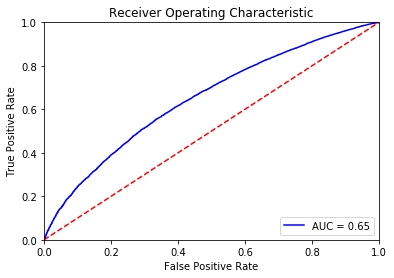

In [0]:
plot_roc_auc(text_classification_test_reduced.published, pred_bow_imbalanced_class.prob_pred)

### Preparation for RNN Classifier

#### Tokenization

In [0]:
from keras.preprocessing.text import Tokenizer

#prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(comment_train)

#execute tokenization
X_train = tokenizer.texts_to_sequences(comment_train)
X_test = tokenizer.texts_to_sequences(comment_test)

#adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1  

Using TensorFlow backend.


In [0]:
#print position of example words in vocabulary (words are ordered by frequency)
for word in ['auto', 'seh']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

auto: 337
seh: 1231


#### Train Word2Vec Embedding for Embedding Layer

In [0]:
import gensim
from nltk import word_tokenize
import nltk
nltk.download('punkt')

#remove NAs
text_classification_train['text'].dropna(inplace=True)

#apply word tokenization
comment_train_w2v = text_classification_train['text'].apply(word_tokenize)

In [0]:
#selecting comments to train embedding
comment_train_w2v = comment_train_w2v[:1000000]

#train word2vec embedding
model = gensim.models.Word2Vec(sentences=comment_train_w2v,
                               min_count = 1, #frequency benchmark
                               size = 300, #embedding size
                               window = 5, #I played around with the size of the context and landed at 5
                               iter = 40, #to speed it up the training a little bit a lower 'iter' is possible since it defines how many times the training code will run through the data set
                               sg = 1)

In [0]:
#check example for model results
model.most_similar('merkel')

In [0]:
# Storing the trained word2vec model
filename = 'embedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

In [0]:
#download file
from google.colab import files
files.download('embedding_word2vec.txt') 

#### Import Word2Vec Embedding

In [0]:
# Loading the word embedding created as a directory of words to vectors
import os

embeddings_index_word2vec={}

#open embedding from file
f = open("/content/drive/My Drive/embedding_word2vec_1m.txt", encoding = 'utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = values[1:]
    embeddings_index_word2vec[word] = coefs
f.close()

In [0]:
#creating the embedding matrix for the embedding layer using word2vec for the main model
import numpy as np

#setting embedding dimension
embedding_dim = 300

#extracting word indices
word_index = tokenizer.word_index

#determine length of embedding vocabulary
num_words = len(word_index) + 1

#prepare embedding matrix
embedding_matrix_word2vec = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector_word2vec = embeddings_index_word2vec.get(word)
    if embedding_vector_word2vec is not None:
        #words not found in embedding index will be set to zero
        embedding_matrix_word2vec[i] = embedding_vector_word2vec

In [0]:
#function to prepare data for the rnn model training
def prepare_data_rnn(comment_train, comment_test):
    
    ### Tokenization:
    from keras.preprocessing.text import Tokenizer

    #prepare tokenization
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(comment_train)

    #apply tokenization on train and test set
    X_train = tokenizer.texts_to_sequences(comment_train)
    X_test = tokenizer.texts_to_sequences(comment_test)

    #adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    ### Padding Sequences:
    #set maximum length (number of words) for comment
    #shorter comments are filled with zeros at the end
    from keras.preprocessing.sequence import pad_sequences

    #setting maximum sequence length
    maxlen = 100

    #padding sequences for train and test set
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    return X_train, X_test

In [0]:
#apply data preparation for rnn model
X_train, X_test = prepare_data_rnn(comment_train, comment_test)

### RNN - Classifier

In [0]:
#setting rnn parameters for all models
LSTM_NODES = 64
DROPOUT = 0.1
RECURRENT_DROPOUT = 0.1
DENSE1_NODES = 64
DENSE2_NODES = 1
EPOCHS = 20
BATCH_SIZE = 512

In [0]:
#using RNN model with Embedding and bidirectional LSTM layer for classification
from keras.models import Sequential
from keras import layers
from keras.layers import LSTM, Dropout
from keras.layers import Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping

#setting embedding dimensionality
embedding_dim = 300

#initialize RNN model
model = Sequential()

#add embedding layer
model.add(layers.Embedding(input_dim=num_words, 
                           output_dim=embedding_dim, 
                           embeddings_initializer = Constant(embedding_matrix_word2vec),  
                           trainable = False))

#add bidirectional LSTM layer
model.add(Bidirectional(LSTM(LSTM_NODES, dropout = DROPOUT, recurrent_dropout = RECURRENT_DROPOUT)))

# model.add(Bidirectional(LSTM(LSTM_NODES, dropout = DROPOUT, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True)))
# model.add(LSTM(LSTM_NODES, dropout = DROPOUT, recurrent_dropout = RECURRENT_DROPOUT))

#add additional dropout layer
model.add(Dropout(DROPOUT))

#adding dense layers to produce required output probability
model.add(layers.Dense(DENSE1_NODES, activation='relu'))
model.add(layers.Dense(DENSE2_NODES, activation='sigmoid'))


#complite the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         63426600  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 63,621,801
Trainable params: 195,201
Non-trainable params: 63,426,600
_________________________________________________________________


In [0]:
#setting early stopping parameter
ea = EarlyStopping(monitor="val_loss", mode="min", patience=5)

#train rnn model
model.fit(X_train, label_train,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, label_test),
          callbacks=[ea],
          batch_size=BATCH_SIZE)

Train on 146292 samples, validate on 50000 samples
Epoch 1/20
146292/146292 [==============================] - 84s 577us/step - loss: 0.3820 - acc: 0.8682 - val_loss: 0.3617 - val_acc: 0.8716
Epoch 2/20
146292/146292 [==============================] - 80s 548us/step - loss: 0.3654 - acc: 0.8684 - val_loss: 0.3591 - val_acc: 0.8716
Epoch 3/20
146292/146292 [==============================] - 80s 549us/step - loss: 0.3626 - acc: 0.8684 - val_loss: 0.3573 - val_acc: 0.8717
Epoch 4/20
146292/146292 [==============================] - 79s 543us/step - loss: 0.3587 - acc: 0.8685 - val_loss: 0.3570 - val_acc: 0.8716
Epoch 5/20
146292/146292 [==============================] - 79s 543us/step - loss: 0.3555 - acc: 0.8686 - val_loss: 0.3585 - val_acc: 0.8716
Epoch 6/20
146292/146292 [==============================] - 79s 543us/step - loss: 0.3515 - acc: 0.8690 - val_loss: 0.3585 - val_acc: 0.8715
Epoch 7/20
146292/146292 [==============================] - 80s 547us/step - loss: 0.3470 - acc: 0.8697

In [0]:
#predict class probabilities
pred_rnn_imbalanced = model.predict(X_test)

#### Calculate Evaluation Metrics

In [0]:
#calculate class predictions
pred_rnn_imbalanced_class = class_prediction(pred_rnn_imbalanced)

##### Confusion Matrix

In [0]:
#create confusion matrix
confusion_matrix_rnn_imbalanced = conf_matrix(pred_rnn_imbalanced_class['class_pred'], text_classification_test_reduced.published)
print(confusion_matrix_rnn_imbalanced)

Predicted    0      1
True                 
0           99   6323
1          101  43477


##### Evaluation Metrics: F1, AUC, ACC

In [0]:
import sklearn

#calculate evaluation metrics
f1_rnn_imbalanced = sklearn.metrics.f1_score(text_classification_test_reduced.published, pred_rnn_imbalanced_class.class_pred)
auc_rnn_imbalanced = sklearn.metrics.roc_auc_score(text_classification_test_reduced.published, pred_rnn_imbalanced_class.prob_pred)
acc_rnn_imbalanced = sklearn.metrics.accuracy_score(text_classification_test_reduced.published, pred_rnn_imbalanced_class.class_pred)

print("F1:", f1_rnn_imbalanced)
print("AUC:", auc_rnn_imbalanced)
print("ACC:", acc_rnn_imbalanced)

F1: 0.9312043522028743
AUC: 0.6873616771304765
ACC: 0.87152


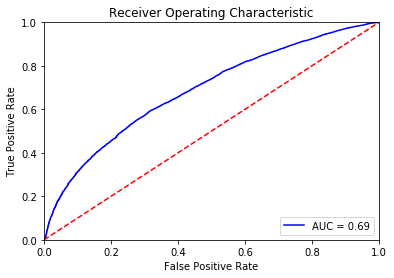

In [0]:
#plotting roc-auc curve
plot_roc_auc(text_classification_test_reduced.published, pred_rnn_imbalanced_class.prob_pred)

In [0]:
#print results of both models
print("F1 BOW Imbalanced:", f1_bow_imbalanced)
print("F1 RNN Imbalanced:", f1_rnn_imbalanced)

print("AUC BOW Imbalanced:", auc_bow_imbalanced)
print("AUC RNN Imbalanced:", auc_rnn_imbalanced)

print("ACC BOW Imbalanced:", acc_bow_imbalanced)
print("ACC RNN Imbalanced:", acc_rnn_imbalanced)

F1 BOW Imbalanced: 0.9225414917451547
F1 RNN Imbalanced: 0.9312043522028743
AUC BOW Imbalanced: 0.6499069299151073
AUC RNN Imbalanced: 0.6873616771304765
ACC BOW Imbalanced: 0.85756
ACC RNN Imbalanced: 0.87152


## Prepare Data for Undersampling

### Perform Undersampling

In [0]:
#calculate imbalancedness for reduced training data
rel_freq1 = pd.Series(label_train).value_counts()       
print(rel_freq1/len(label_train))

True     0.868393
False    0.131607
Name: online, dtype: float64


In [0]:
#calculate imbalancedness for whole training data
rel_freq2 = pd.Series(text_classification_train['published']).value_counts()       
print(rel_freq2/len(text_classification_train['published'])) 

True     0.868807
False    0.131193
Name: online, dtype: float64


In [0]:
### perform undersampling

#extract number of not published comments
count_not_pub_comments = len(text_classification_train_reduced[text_classification_train_reduced['published'] == False])

#get indices of published comments
idx_pub_comments = text_classification_train_reduced[text_classification_train_reduced.published == True].index

#random sample published comments indices
random_indices = np.random.choice(idx_pub_comments, count_not_pub_comments, replace = False)

#get indices of not published comments
idx_not_pub_comments = text_classification_train_reduced[text_classification_train_reduced.published == False].index

#concat non-published indices with sample published ones
under_sample_indices = np.concatenate([idx_not_pub_comments, random_indices])

#construct balanced dataframe
df_under_sample = text_classification_train_reduced.loc[under_sample_indices]

In [0]:
df_under_sample.shape

(38506, 7)

In [0]:
#calculate distribution for undersampled dataset
rel_freq3 = pd.Series(df_under_sample['published']).value_counts()       
print(rel_freq3/len(df_under_sample['published'])) 

print(len(df_under_sample))

True     0.5
False    0.5
Name: online, dtype: float64
38506


## Classification with Undersampled Data

In [0]:
#extracting texts and labels from undersampled data frame
comment = pd.DataFrame()

comment['text'] = df_under_sample['text']
comment['label'] = df_under_sample['published']

comment.head()

,text,label
1565820,och noe dominik nicht schon billig verbraucher...,False
1285135,jup zeigt leitsprache neusprech orwell nahezu ...,False
190277,herman m ganze ddr folklore langweilt nicht da...,False
243479,richtig immer migration europa gab meistens ef...,False
988662,kirchenvertreter froenen paedophilen neigungen...,False


In [0]:
#prepair training set
comment_train = comment['text']
label_train = comment['label']

In [0]:
print(comment_train.shape)
print(comment_test.shape)
print(label_train.shape)
print(label_test.shape)

(38506,)
(50000,)
(38506,)
(50000,)


### BOW Classifier

In [0]:
#bag of words classification
pred_bow_undersample = bow_classification(comment_train=comment_train, comment_test=comment_test)

#### Calculate Evaluation Metrics

In [0]:
#calculate class predictions
pred_bow_undersample_class = class_prediction(pred_bow_undersample)

print(pred_bow_undersample_class[pred_bow_undersample_class['prob_pred'] < 0.5][:5])
print(pred_bow_undersample_class[pred_bow_undersample_class['prob_pred'] >= 0.5][:5])

print(len(pred_bow_undersample_class))
print(text_classification_test_reduced.published[:5])

   prob_pred  class_pred
0   0.001569           0
2   0.394534           0
5   0.414510           0
6   0.347087           0
9   0.190446           0
   prob_pred  class_pred
1   0.977082           1
3   0.562474           1
4   0.828682           1
7   0.670937           1
8   0.685111           1
50000
68418      True
216744     True
278474     True
88057     False
205125     True
Name: online, dtype: bool


##### Confusion Matrix

In [0]:
#construc confusion matrix
confusion_matrix_bow_undersample = conf_matrix(pred_bow_undersample_class['class_pred'], text_classification_test_reduced.published)
print(confusion_matrix_bow_undersample)

Predicted      0      1
True                   
0           4149   2273
1          18878  24700


##### Evaluation Metrics: F1, AUC, ACC

In [0]:
import sklearn

#calculate evaluation metrics
f1_bow_undersample = sklearn.metrics.f1_score(text_classification_test_reduced.published, pred_bow_undersample_class.class_pred)
auc_bow_undersample = sklearn.metrics.roc_auc_score(text_classification_test_reduced.published, pred_bow_undersample_class.prob_pred)
acc_bow_undersample = sklearn.metrics.accuracy_score(text_classification_test_reduced.published, pred_bow_undersample_class.class_pred)

print("F1:", f1_bow_undersample)
print("AUC:", auc_bow_undersample)
print("ACC:", acc_bow_undersample)

F1: 0.7002026902524414
AUC: 0.6457026518413722
ACC: 0.57698


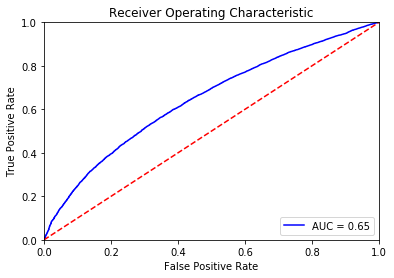

In [0]:
#plot roc-auc curve
plot_roc_auc(text_classification_test_reduced.published, pred_bow_undersample_class.prob_pred)

### Preparation for RNN Classifier

In [0]:
#tokenization and padding of sequences
X_train, X_test = prepare_data_rnn(comment_train, comment_test)

### RNN - Classifier

In [0]:
#setting early stopping parameter
ea = EarlyStopping(monitor="val_loss", mode="min", patience=5)

#train RNN model
model.fit(X_train, label_train,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, label_test),
          callbacks=[ea],
          batch_size=BATCH_SIZE)

Train on 38506 samples, validate on 50000 samples
Epoch 1/20
38506/38506 [==============================] - 24s 630us/step - loss: 0.7038 - acc: 0.5414 - val_loss: 0.6977 - val_acc: 0.5111
Epoch 2/20
38506/38506 [==============================] - 25s 643us/step - loss: 0.6809 - acc: 0.5636 - val_loss: 0.6487 - val_acc: 0.6312
Epoch 3/20
38506/38506 [==============================] - 25s 643us/step - loss: 0.6748 - acc: 0.5757 - val_loss: 0.6871 - val_acc: 0.5445
Epoch 4/20
38506/38506 [==============================] - 25s 639us/step - loss: 0.6661 - acc: 0.5923 - val_loss: 0.6925 - val_acc: 0.5385
Epoch 5/20
38506/38506 [==============================] - 25s 645us/step - loss: 0.6601 - acc: 0.5973 - val_loss: 0.7078 - val_acc: 0.5147
Epoch 6/20
38506/38506 [==============================] - 24s 634us/step - loss: 0.6464 - acc: 0.6189 - val_loss: 0.7265 - val_acc: 0.4876
Epoch 7/20
38506/38506 [==============================] - 25s 645us/step - loss: 0.6340 - acc: 0.6340 - val_loss: 0.

In [0]:
#predict class probabilities
pred_rnn_undersample = model.predict(X_test)

#### Calculate Evaluation Metrics

In [0]:
#calculate class predictions
pred_rnn_undersample_class = class_prediction(pred_rnn_undersample)

##### Confusion Matrix

In [0]:
#construct confusion matrix
confusion_matrix_rnn_undersample = conf_matrix(pred_rnn_undersample_class['class_pred'], text_classification_test_reduced.published)
print(confusion_matrix_rnn_undersample)

Predicted      0      1
True                   
0           4699   1723
1          25940  17638


##### Evaluation Metrics: F1, AUC, ACC

In [0]:
import sklearn

#calculate evaluation metrics
f1_rnn_undersample = sklearn.metrics.f1_score(text_classification_test_reduced.published, pred_rnn_undersample_class.class_pred)
auc_rnn_undersample = sklearn.metrics.roc_auc_score(text_classification_test_reduced.published, pred_rnn_undersample_class.prob_pred)
acc_rnn_undersample = sklearn.metrics.accuracy_score(text_classification_test_reduced.published, pred_rnn_undersample_class.class_pred)

print("F1:", f1_rnn_undersample)
print("AUC:", auc_rnn_undersample)
print("ACC:", acc_rnn_undersample)

F1: 0.5604791941403581
AUC: 0.5998135996982126
ACC: 0.44674


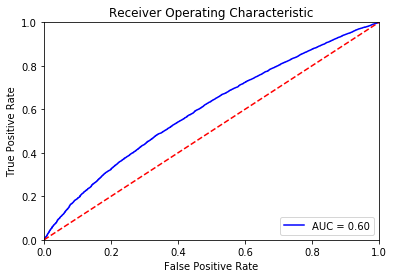

In [0]:
#plot roc-auc curve
plot_roc_auc(text_classification_test_reduced.published, pred_rnn_undersample_class.prob_pred)

In [0]:
#print results of both models
print("F1 BOW Imbalanced:", f1_bow_undersample)
print("F1 RNN Imbalanced:", f1_rnn_undersample)

print("AUC BOW Imbalanced:", auc_bow_undersample)
print("AUC RNN Imbalanced:", auc_rnn_undersample)

print("ACC BOW Imbalanced:", acc_bow_undersample)
print("ACC RNN Imbalanced:", acc_rnn_undersample)

F1 BOW Imbalanced: 0.7002026902524414
F1 RNN Imbalanced: 0.5604791941403581
AUC BOW Imbalanced: 0.6457026518413722
AUC RNN Imbalanced: 0.5998135996982126
ACC BOW Imbalanced: 0.57698
ACC RNN Imbalanced: 0.44674


## Classification with generated Text using German Glove Embedding

### Prepare Data to use Generated GloVe Comments

#### Import and Clean Generated Comments

In [0]:
#specify absolute difference between comments
abs_difference = len(text_classification_train_reduced[text_classification_train_reduced['published'] == True]) - len(text_classification_train_reduced[text_classification_train_reduced['published'] == False])

print('Number of necessary generated comments:', abs_difference)

Number of necessary generated comments: 107786


In [0]:
#import generated comments
glove_gen_comments = pd.read_csv("/content/drive/My Drive/glove_generated_30k.csv", encoding='ISO 8859-1')
glove_gen_comments = pd.DataFrame(glove_gen_comments['text'])

print(glove_gen_comments.head())
print(len(glove_gen_comments))

                                                text
0  als sozialforschung hinzu im koran wird wie ni...
1  sollte sollen sie meine auf allen steht aber i...
2  integrationsbeauftragte region das nicht mit l...
3  jetzt in von die laberwerkstatt blauen ungläub...
4  nur eine parteien zu links der afd rügt löw fr...


30133

In [0]:
#select comments to balance data
#glove_gen_comments_sample = pd.DataFrame(glove_gen_comments.text.sample(n = abs_difference))
#len(glove_gen_comments_sample)

In [0]:
#apply cleaning to generated comments
glove_gen_comments['text'] = replace_umlaute(glove_gen_comments['text'])
print(glove_gen_comments['text'][:5])

0    als sozialforschung hinzu im koran wird wie ni...
1    sollte sollen sie meine auf allen steht aber i...
2    integrationsbeauftragte region das nicht mit l...
3    jetzt in von die laberwerkstatt blauen unglaeu...
4    nur eine parteien zu links der afd ruegt loew ...
Name: text, dtype: object


#### Remove Stop Words

In [0]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import string

# Defining a function for text preparation for classification
stop_words = set(stopwords.words('german'))
# Detokenizer combines tokenized elements
detokenizer = TreebankWordDetokenizer()

stop_words = list(stop_words)

#filter certain stop words from the list e.g. kein, nicht
sw_remove = ['kein', 'keine', 'keinem', 'keinen', 'keiner', 'keines', 'nicht', 'nichts']

for x in sw_remove:
    if x in stop_words:
        stop_words.remove(x)

stop_words = set(stop_words)

def prepare_text_class(text):
    
    # Remove URLs
    text = re.sub(r'https\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www.\S+', '', text)
    
    # Remove references to Usernames
    text = re.sub(r'@\S+', '', text)
    
    # Remove line breaks
    text = re.sub("\n|\r", ' ', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s{2,}', ' ', text)
    
    # devide the text into sequences of words and transform the tokens into lower case. This avoids having multiple copies of the same word.
    text = word_tokenize(text.lower())
    
    # remove the commonly occuring words. For this purpose, I use predefined libraries. In the same step I remove the non alphabetic tokens.
    text = [token for token in text if token not in stop_words and token.isalpha()]

    # remove the punctuation since it doesn't give any extra information while treating the text. Furthermore, it helps us to reduce the size of the training data.
    table = str.maketrans('', '', string.punctuation)
    text = [token.translate(table) for token in text]

    return detokenizer.detokenize(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
#clean glove generated comments
glove_gen_comments['text'] = glove_gen_comments['text'].apply(prepare_text_class)

In [0]:
glove_gen_comments['text'].head()

0    sozialforschung hinzu koran nicht buergermeist...
1    sollen steht immer verlieren ja dafuer moege t...
2    integrationsbeauftragte region nicht lauter ei...
3    laberwerkstatt blauen unglaeubigen irrtum lueg...
4    parteien links afd ruegt loew freiheit hoelle ...
Name: text, dtype: object

### Stemming

In [0]:
#apply stemming
nrows = len(glove_gen_comments)
stem_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    stem_list = []
    
    # Save the text and its words into an object
    text = glove_gen_comments.iloc[row]['text']
        
    # Stemming text
    stem_text = stemmer.stem(text)
    
    # Append to the list containing the texts
    stem_text_list.append(stem_text)

glove_gen_comments['text'] = stem_text_list

#### Extending original Data Set with generated comments

In [0]:
#specify number of comments to use for training set based on number of available generated comments for GloVe
perc_published = 1-val_counts.counts[1]/val_counts.counts[0]
perc_offline = val_counts.counts[1]/val_counts.counts[0]

#calculate difference between percentage
perc_difference = perc_published - perc_offline

#total number of available real comments
total_comments = len(text_classification_train)

#number of available real published comments
number_published_comments = sum(text_classification_train['published'] == True)

#number of available real offline comments
number_offline_comments = sum(text_classification_train['published'] == False)

#specify necessary comments to use whole dataset
necessary_comments = (perc_difference*total_comments)-number_offline_comments

#set number of available generated comments
gen_comments = len(glove_gen_comments)

#ratio between generated comments and necessary comments
gen_necessary_ratio = gen_comments/necessary_comments

#reduce number of offline comments by ratio of actual and necessary generated comments
number_offline_comments_new = number_offline_comments*gen_necessary_ratio

#calculate total offline comments (reduced real comments + generated comments)
total_offline = number_offline_comments_new + gen_comments

#calculate how many observations from training set can be used --> real offline comments (gen + real - gen) = total published comments)
total_comments_final_glove = int((total_offline*2)-gen_comments)


In [0]:
#adding generated comments to original data
text_classification_train_reduced_small_glove = text_classification_train_reduced.sample(n=total_comments_final_glove, random_state=1)
df_gen_glove = text_classification_train_reduced_small_glove[['text', 'published']].copy()
df_gen_glove.head()

,text,online
1236267,erlauben stamp kannte mann bisher nicht,False
722238,glaube sahara gibt s genug,True
312585,zunaechst vielen dank georg differenzierten kl...,True
1334051,filiz message verstanden suedliche server weit...,False
531370,dafuer ausfuehrlich lesen seibert denkt fuehlt,False


In [0]:
#extension dataframe
glove_gen_ext = pd.DataFrame(glove_gen_comments)
glove_gen_ext['published'] = False
glove_gen_ext.head()

,text,online
0,sozialforschung hinzu koran nicht buergermeist...,False
1,sollen steht immer verlieren ja dafuer moege t...,False
2,integrationsbeauftragte region nicht lauter ei...,False
3,laberwerkstatt blauen unglaeubigen irrtum lueg...,False
4,parteien links afd ruegt loew freiheit hoelle ...,False


In [0]:
#concatenating data frames
df_gen_glove = pd.concat([df_gen_glove, glove_gen_ext])
len(df_gen_glove)

74215

In [0]:
#check balancedness
df_gen_glove['published'].value_counts()

True     38195
False    36020
Name: online, dtype: int64

## Classification with balanced Dataset using GloVe Comments

In [0]:
#extracting texts and labels from data frame
comment = pd.DataFrame()

comment['text'] = df_gen_glove['text']
comment['label'] = df_gen_glove['published']

comment.head()

,text,label
1236267,erlauben stamp kannte mann bisher nicht,False
722238,glaube sahara gibt s genug,True
312585,zunaechst vielen dank georg differenzierten kl...,True
1334051,filiz message verstanden suedliche server weit...,False
531370,dafuer ausfuehrlich lesen seibert denkt fuehlt,False


In [0]:
#prepare training set
comment_train = comment['text']
label_train = comment['label']

In [0]:
print(comment_train.shape)
print(comment_test.shape)
print(label_train.shape)
print(label_test.shape)

(74215,)
(50000,)
(74215,)
(50000,)


### BOW Classifier

In [0]:
#bag of words classification
pred_bow_oversample_glove = bow_classification(comment_train=comment_train, comment_test=comment_test)
print(pred_bow_oversample_glove[pred_bow_oversample_glove < 0.5])

[0.01444025 0.41938359 0.49668464 ... 0.18556191 0.219572   0.4175143 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Calculate Evaluation Metrics

In [0]:
#calculate class predictions
pred_bow_oversample_glove_class = class_prediction(pred_bow_oversample_glove)

##### Confusion Matrix

In [0]:
#construct confusion matrix
confusion_matrix_bow_oversample_glove = conf_matrix(pred_bow_oversample_glove_class['class_pred'], text_classification_test_reduced.published)
print(confusion_matrix_bow_oversample_glove)

Predicted      0      1
True                   
0           2555   3867
1          10747  32831


##### Evaluation Metrics: F1, AUC, ACC

In [0]:
import sklearn

#calculate evaluation metrics
f1_bow_oversample_glove = sklearn.metrics.f1_score(text_classification_test_reduced.published, pred_bow_oversample_glove_class.class_pred)
auc_bow_oversample_glove = sklearn.metrics.roc_auc_score(text_classification_test_reduced.published, pred_bow_oversample_glove_class.prob_pred)
acc_bow_oversample_glove = sklearn.metrics.accuracy_score(text_classification_test_reduced.published, pred_bow_oversample_glove_class.class_pred)

print("F1:", f1_bow_oversample_glove)
print("AUC:", auc_bow_oversample_glove)
print("ACC:", acc_bow_oversample_glove)

F1: 0.8179530619363197
AUC: 0.6213615251104778
ACC: 0.70772


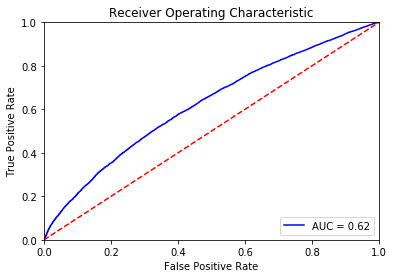

In [0]:
#plot roc-auc curve
plot_roc_auc(text_classification_test_reduced.published, pred_bow_oversample_glove_class.prob_pred)

### Preparation for RNN Classifier

In [0]:
#tokenization and padding of sequences
X_train, X_test = prepare_data_rnn(comment_train, comment_test)

### RNN - Classifier

In [0]:
#setting early stopping parameter
ea = EarlyStopping(monitor="val_loss", mode="min", patience=5)

#train RNN model
model.fit(X_train, label_train,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, label_test),
          callbacks=[ea],
          batch_size=BATCH_SIZE)

Train on 74215 samples, validate on 50000 samples
Epoch 1/20
74215/74215 [==============================] - 43s 576us/step - loss: 0.6399 - acc: 0.6188 - val_loss: 0.6310 - val_acc: 0.6257
Epoch 2/20
74215/74215 [==============================] - 43s 579us/step - loss: 0.5670 - acc: 0.6828 - val_loss: 0.5606 - val_acc: 0.7321
Epoch 3/20
74215/74215 [==============================] - 42s 571us/step - loss: 0.5415 - acc: 0.7094 - val_loss: 0.5735 - val_acc: 0.7031
Epoch 4/20
74215/74215 [==============================] - 43s 578us/step - loss: 0.5229 - acc: 0.7246 - val_loss: 0.5709 - val_acc: 0.7120
Epoch 5/20
74215/74215 [==============================] - 43s 577us/step - loss: 0.5043 - acc: 0.7405 - val_loss: 0.5324 - val_acc: 0.7487
Epoch 6/20
74215/74215 [==============================] - 43s 574us/step - loss: 0.4874 - acc: 0.7561 - val_loss: 0.6092 - val_acc: 0.6761
Epoch 7/20
74215/74215 [==============================] - 43s 582us/step - loss: 0.4721 - acc: 0.7663 - val_loss: 0.

In [0]:
#predict class probabilities
pred_rnn_oversample_glove = model.predict(X_test)

#### Calculate Evaluation Metrics

In [0]:
#calculate class predictions
pred_rnn_oversample_glove_class = class_prediction(pred_rnn_oversample_glove)

##### Confusion Matrix

In [0]:
#construct confusion matrix
confusion_matrix_rnn_oversample_glove = conf_matrix(pred_rnn_oversample_glove_class['class_pred'], text_classification_test_reduced.published)
print(confusion_matrix_rnn_oversample_glove)

Predicted      0      1
True                   
0           2497   3925
1          11796  31782


##### Evaluation Metrics: F1, AUC, ACC

In [0]:
import sklearn

#calculate evaluation metrics
f1_rnn_oversample_glove = sklearn.metrics.f1_score(text_classification_test_reduced.published, pred_rnn_oversample_glove_class.class_pred)
auc_rnn_oversample_glove = sklearn.metrics.roc_auc_score(text_classification_test_reduced.published, pred_rnn_oversample_glove_class.prob_pred)
acc_rnn_oversample_glove = sklearn.metrics.accuracy_score(text_classification_test_reduced.published, pred_rnn_oversample_glove_class.class_pred)

print("F1:", f1_rnn_oversample_glove)
print("AUC:", auc_rnn_oversample_glove)
print("ACC:", acc_rnn_oversample_glove)

F1: 0.8017153307687457
AUC: 0.5958927458031953
ACC: 0.68558


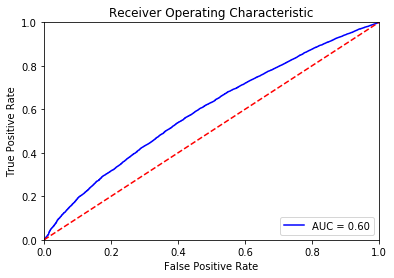

In [0]:
#plot roc-auc curve
plot_roc_auc(text_classification_test_reduced.published, pred_rnn_oversample_glove_class.prob_pred)

In [0]:
#print results of both models
print("F1 BOW Oversampled Glove:", f1_bow_oversample_glove)
print("F1 RNN Oversampled Glove:", f1_rnn_oversample_glove)

print("AUC BOW Oversampled Glove:", auc_bow_oversample_glove)
print("AUC RNN Oversampled Glove:", auc_rnn_oversample_glove)

print("ACC BOW Oversampled Glove:", acc_bow_oversample_glove)
print("ACC RNN Oversampled Glove:", acc_rnn_oversample_glove)

F1 BOW Oversampled Glove: 0.8179530619363197
F1 RNN Oversampled Glove: 0.8017153307687457
AUC BOW Oversampled Glove: 0.6213615251104778
AUC RNN Oversampled Glove: 0.5958927458031953
ACC BOW Oversampled Glove: 0.70772
ACC RNN Oversampled Glove: 0.68558


## Classification with generated Text using English GPT-2 Embedding

### Prepare Data to use Generated GPT-2 Comments

#### Import and Clean Generated Comments

In [0]:
#specify absolute difference between comments
abs_difference = len(text_classification_train_reduced[text_classification_train_reduced['published'] == True]) - len(text_classification_train_reduced[text_classification_train_reduced['published'] == False])

print('Number of necessary generated comments:', abs_difference)

Number of necessary generated comments: 107786


In [0]:
#import generated gpt-2 comments
#import package for regular expressions
import re

#read generated text file
gpt2_gen_comments = open(r"/content/drive/My Drive/gpt2_gentext.txt", encoding = "UTF-8")

#read lines in file
gpt2_gen_comments = gpt2_gen_comments.readlines()

#remove line break operators
gpt2_gen_comments = [re.sub(r'\n', '', x) for x in gpt2_gen_comments]

#remove separation characters
gpt2_gen_comments = [re.sub(r'====================', '', x) for x in gpt2_gen_comments]

#remove empty strings
gpt2_gen_comments = list(filter(None, gpt2_gen_comments))

print(gpt2_gen_comments[:10])
print(len(gpt2_gen_comments))

gpt2_gen_comments = pd.DataFrame(gpt2_gen_comments, columns = ['text'])

gpt2_gen_comments[:10]

['t hat das ganze schon schwer auszuhalten nichts bewirken lassen nicht einmal die kirche mit merkel und der kanzlerin in nichts nachhilfe kurz nach der wahl hat sich das überhaupt erst in der frage der regelmässigkeit und der kirche erledigt', 'einer der schlimmsten sachen wie sie das leben auszusprechen ist auch ein menschenrecht das ist selbst ein grund', 'schon wieder der erste schritt in der türkei eines mädchens', 'ein einzelfall einzelfall', 'die wähler haben ein problem mit dem andern gemeint', 'man kann es sich ja ganz leicht um die bevölkerung bitten die probleme zu benennen eine neue identitaet wie das deutsche volk in dem sie sich auf die', 'z niedergeknählt', 'es ist schon ein witz dass die deutschen auch so viele probleme gaben', 'ich finde die ganze bande sollte einen guten job bekommen und sollte so langsam immer noch meinen wer dann in deutschland aufhört wird nicht mehr ausgeschöpft dann gibt es keine große aufmerksamkeit in d wenn man sich mit den bekannten schwierig

,text
0,t hat das ganze schon schwer auszuhalten nicht...
1,einer der schlimmsten sachen wie sie das leben...
2,schon wieder der erste schritt in der türkei e...
3,ein einzelfall einzelfall
4,die wähler haben ein problem mit dem andern ge...
5,man kann es sich ja ganz leicht um die bevölke...
6,z niedergeknählt
7,es ist schon ein witz dass die deutschen auch ...
8,ich finde die ganze bande sollte einen guten j...
9,ich kann auf keine einzige lösungen entstehen ...


In [0]:
#select comments to balance data
gpt2_gen_comments = pd.DataFrame(gpt2_gen_comments.text.sample(n = abs_difference, random_state = 1))
len(gpt2_gen_comments)

107786

In [0]:
#apply cleaning to generated comments
gpt2_gen_comments['text'] = replace_umlaute(gpt2_gen_comments['text'])
print(gpt2_gen_comments['text'][:5])

102463    st waere das ende des deutschen volkes wenn es...
89026     drei zwei stunden mit migrationshintergrund au...
109041    gibt es hier ein einziges spiel mit deutschen ...
99645     gibt es eigentlich keine untersuchungshaft auf...
80095     en von einem einzigen ausreisepflichtigen auf ...
Name: text, dtype: object


#### Remove Stop Words

In [0]:
#cleaning generated text
gpt2_gen_comments['text'] = gpt2_gen_comments['text'].apply(prepare_text_class)

In [0]:
gpt2_gen_comments['text'].head()

102463    st waere ende deutschen volkes darum geht eu d...
89026     drei zwei stunden migrationshintergrund usa vi...
109041    gibt einziges spiel deutschen schnauze halten ...
99645     gibt eigentlich keine untersuchungshaft proble...
80095     en einzigen ausreisepflichtigen gefaehrliche r...
Name: text, dtype: object

### Stemming

In [0]:
nrows = len(gpt2_gen_comments)
stem_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    stem_list = []
    
    # Save the text and its words into an object
    text = gpt2_gen_comments.iloc[row]['text']
        
    # Stemming text
    stem_text = stemmer.stem(text)
    
    # Append to the list containing the texts
    stem_text_list.append(stem_text)

gpt2_gen_comments['text'] = stem_text_list

#### Extending original Data Set with generated comments

In [0]:
#adding generated comments to original data
df_gen_gpt2 = text_classification_train_reduced[['text', 'published']].copy()
df_gen_gpt2.head()

,text,online
393613,haette eigentlich titelseite welt online gehoert,True
947179,bitterer witz aufs kopftuch uebertragen na gut...,True
14697,akk zementiert merkel geschaffen neue sed sozi...,True
979769,ja supi ganz toll nicht meinungen auseinanders...,True
255632,schwaetzt mal gerne thema herr kreuzabnehm,True


In [0]:
#extension dataframe
gpt2_gen_ext = pd.DataFrame(gpt2_gen_comments)

#setting label for generated comments
gpt2_gen_ext['published'] = False
gpt2_gen_ext.head()

,text,online
102463,st waere ende deutschen volkes darum geht eu d...,False
89026,drei zwei stunden migrationshintergrund usa vi...,False
109041,gibt einziges spiel deutschen schnauze halten ...,False
99645,gibt eigentlich keine untersuchungshaft proble...,False
80095,en einzigen ausreisepflichtigen gefaehrliche r...,False


In [0]:
#concatenating data frames
df_gen_gpt2 = pd.concat([df_gen_gpt2, gpt2_gen_ext])
len(df_gen_gpt2)

254078

In [0]:
#check balancedness
df_gen_gpt2['published'].value_counts()

True     127039
False    127039
Name: online, dtype: int64

## Classification with balanced Dataset using GPT-2 Comments

In [0]:
#extracting texts and labels from data frame
comment = pd.DataFrame()

comment['text'] = df_gen_gpt2['text']
comment['label'] = df_gen_gpt2['published']

comment.head()

,text,label
393613,haette eigentlich titelseite welt online gehoert,True
947179,bitterer witz aufs kopftuch uebertragen na gut...,True
14697,akk zementiert merkel geschaffen neue sed sozi...,True
979769,ja supi ganz toll nicht meinungen auseinanders...,True
255632,schwaetzt mal gerne thema herr kreuzabnehm,True


In [0]:
#prepare training set
comment_train = comment['text']
label_train = comment['label']

In [0]:
print(comment_train.shape)
print(comment_test.shape)
print(label_train.shape)
print(label_test.shape)

(254078,)
(50000,)
(254078,)
(50000,)


### BOW Classifier

In [0]:
#bag of words classification
pred_bow_oversample_gpt2 = bow_classification(comment_train=comment_train, comment_test=comment_test)

#### Calculate Evaluation Metrics

In [0]:
#calculate class predictions
pred_bow_oversample_gpt2_class = class_prediction(pred_bow_oversample_gpt2)

##### Confusion Matrix

In [0]:
#construct confusion matrix
confusion_matrix_bow_oversample_gpt2 = conf_matrix(pred_bow_oversample_gpt2_class['class_pred'], text_classification_test_reduced.published)
print(confusion_matrix_bow_oversample_gpt2)

Predicted     0      1
True                  
0          2136   4286
1          8535  35043


##### Evaluation Metrics: F1, AUC, ACC

In [0]:
import sklearn

#calculate evaluation metrics
f1_bow_oversample_gpt2 = sklearn.metrics.f1_score(text_classification_test_reduced.published, pred_bow_oversample_gpt2_class.class_pred)
auc_bow_oversample_gpt2 = sklearn.metrics.roc_auc_score(text_classification_test_reduced.published, pred_bow_oversample_gpt2_class.prob_pred)
acc_bow_oversample_gpt2 = sklearn.metrics.accuracy_score(text_classification_test_reduced.published, pred_bow_oversample_gpt2_class.class_pred)

print("F1:", f1_bow_oversample_gpt2)
print("AUC:", auc_bow_oversample_gpt2)
print("ACC:", acc_bow_oversample_gpt2)

F1: 0.8453568456222031
AUC: 0.6275416236573419
ACC: 0.74358


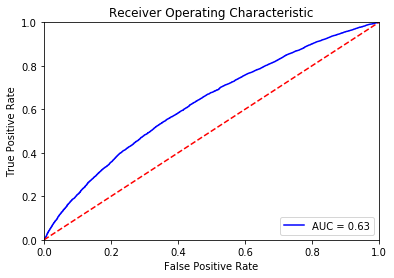

In [0]:
#plot roc-auc curve
plot_roc_auc(text_classification_test_reduced.published, pred_bow_oversample_gpt2_class.prob_pred)

### Preparation for RNN Classifier

In [0]:
#tokenization and padding of sequences
X_train, X_test = prepare_data_rnn(comment_train, comment_test)

### RNN - Classifier

In [0]:
#setting early stopping parameter
ea = EarlyStopping(monitor="val_loss", mode="min", patience=5)

#train RNN model
model.fit(X_train, label_train,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, label_test),
          callbacks=[ea],
          batch_size=BATCH_SIZE)

Train on 254078 samples, validate on 50000 samples
Epoch 1/20
254078/254078 [==============================] - 133s 522us/step - loss: 0.4807 - acc: 0.7717 - val_loss: 0.5365 - val_acc: 0.7517
Epoch 2/20
254078/254078 [==============================] - 132s 520us/step - loss: 0.4025 - acc: 0.8218 - val_loss: 0.4734 - val_acc: 0.7961
Epoch 3/20
254078/254078 [==============================] - 131s 516us/step - loss: 0.3785 - acc: 0.8364 - val_loss: 0.4643 - val_acc: 0.8039
Epoch 4/20
254078/254078 [==============================] - 131s 516us/step - loss: 0.3639 - acc: 0.8446 - val_loss: 0.5145 - val_acc: 0.7766
Epoch 5/20
254078/254078 [==============================] - 131s 514us/step - loss: 0.3518 - acc: 0.8519 - val_loss: 0.4824 - val_acc: 0.7974
Epoch 6/20
254078/254078 [==============================] - 131s 514us/step - loss: 0.3432 - acc: 0.8563 - val_loss: 0.4996 - val_acc: 0.7898
Epoch 7/20
254078/254078 [==============================] - 131s 514us/step - loss: 0.3353 - acc:

In [0]:
#predict class probabilities
pred_rnn_oversample_gpt2 = model.predict(X_test)

#### Calculate Evaluation Metrics

In [0]:
#calculate class predictions
pred_rnn_oversample_gpt2_class = class_prediction(pred_rnn_oversample_gpt2)

##### Confusion Matrix

In [0]:
#construct confusion matrix
confusion_matrix_rnn_oversample_gpt2 = conf_matrix(pred_rnn_oversample_gpt2_class['class_pred'], text_classification_test_reduced.published)
print(confusion_matrix_rnn_oversample_gpt2)

Predicted     0      1
True                  
0          1390   5032
1          5708  37870


##### Evaluation Metrics: F1, AUC, ACC

In [0]:
import sklearn

#calculate evaluation metrics
f1_rnn_oversample_gpt2 = sklearn.metrics.f1_score(text_classification_test_reduced.published, pred_rnn_oversample_gpt2_class.class_pred)
auc_rnn_oversample_gpt2 = sklearn.metrics.roc_auc_score(text_classification_test_reduced.published, pred_rnn_oversample_gpt2_class.prob_pred)
acc_rnn_oversample_gpt2 = sklearn.metrics.accuracy_score(text_classification_test_reduced.published, pred_rnn_oversample_gpt2_class.class_pred)

print("F1:", f1_rnn_oversample_gpt2)
print("AUC:", auc_rnn_oversample_gpt2)
print("ACC:", acc_rnn_oversample_gpt2)

F1: 0.8758094357076781
AUC: 0.6090585356177668
ACC: 0.7852


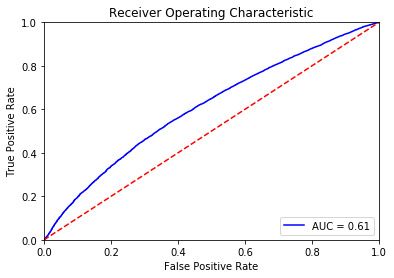

In [0]:
#plot roc-auc curve
plot_roc_auc(text_classification_test_reduced.published, pred_rnn_oversample_gpt2_class.prob_pred)

In [0]:
#print results of both models
print("F1 BOW Oversampled GPT-2:", f1_bow_oversample_gpt2)
print("F1 RNN Oversampled GPT-2:", f1_rnn_oversample_gpt2)

print("AUC BOW Oversampled GPT-2:", auc_bow_oversample_gpt2)
print("AUC RNN Oversampled GPT-2:", auc_rnn_oversample_gpt2)

print("ACC BOW Oversampled GPT-2:", acc_bow_oversample_gpt2)
print("ACC RNN Oversampled GPT-2:", acc_rnn_oversample_gpt2)

F1 BOW Oversampled GPT-2: 0.8453568456222031
F1 RNN Oversampled GPT-2: 0.8758094357076781
AUC BOW Oversampled GPT-2: 0.6275416236573419
AUC RNN Oversampled GPT-2: 0.6090585356177668
ACC BOW Oversampled GPT-2: 0.74358
ACC RNN Oversampled GPT-2: 0.7852


## Saving Predictions

In [0]:
#dataframe with predictions
pred_data = {'bow_imbalanced':pred_rnn_imbalanced_class.prob_pred,
             'rnn_imbalanced':pred_rnn_imbalanced_class.prob_pred,
             'bow_undersample':pred_bow_undersample_class.prob_pred,
             'rnn_undersample':pred_rnn_undersample_class.prob_pred,
             'bow_glove':pred_bow_oversample_glove_class.prob_pred,
             'rnn_glove':pred_rnn_oversample_glove_class.prob_pred,
             'bow_gpt2':pred_bow_oversample_gpt2_class.prob_pred,
             'rnn_gpt2':pred_rnn_oversample_gpt2_class.prob_pred,
             'true_value':list(text_classification_test_reduced.published.astype(int))}

pred_df = pd.DataFrame(pred_data)

pred_df.head()

,bow_imbalanced,rnn_imbalanced,bow_undersample,rnn_undersample,bow_glove,rnn_glove,bow_gpt2,rnn_gpt2,true_value
0,0.671189,0.671189,0.001569,0.224269,0.014440,0.267475,0.006568,0.048076,1
1,0.986998,0.986998,0.977082,0.698867,0.961582,0.619096,0.999947,0.951166,1
2,0.804610,0.804610,0.394534,0.379952,0.419384,0.789161,0.473426,0.583110,1
3,0.728797,0.728797,0.562474,0.370842,0.812884,0.881891,0.710474,0.720110,0
4,0.946659,0.946659,0.828682,0.385463,0.744797,0.262660,0.949494,0.889298,1


In [0]:
#save predictions
pred_df.to_csv('predictions.csv')

## Comparing Results

In [0]:
#printing all results of all models for each setting
print("F1 BOW Imbalanced:", f1_bow_imbalanced)
print("F1 RNN Imbalanced:", f1_rnn_imbalanced)
print("F1 BOW Undersampled:", f1_bow_undersample)
print("F1 RNN Undersampled:", f1_rnn_undersample)
print("F1 BOW Oversampled GloVe:", f1_bow_oversample_glove)
print("F1 RNN Oversampled GloVe:", f1_rnn_oversample_glove)
print("F1 BOW Oversampled GPT-2:", f1_bow_oversample_gpt2)
print("F1 RNN Oversampled GPT-2:", f1_rnn_oversample_gpt2)
print('')
print("AUC BOW Imbalanced:", auc_bow_imbalanced)
print("AUC RNN Imbalanced:", auc_rnn_imbalanced)
print("AUC BOW Undersampled:", auc_bow_undersample)
print("AUC RNN Undersampled:", auc_rnn_undersample)
print("AUC BOW Oversampled GloVe:", auc_bow_oversample_glove)
print("AUC RNN Oversampled GloVe:", auc_rnn_oversample_glove)
print("AUC BOW Oversampled GPT-2:", auc_bow_oversample_gpt2)
print("AUC RNN Oversampled GPT-2:", auc_rnn_oversample_gpt2)
print('')
print("ACC BOW Imbalanced:", acc_bow_imbalanced)
print("ACC RNN Imbalanced:", acc_rnn_imbalanced)
print("ACC BOW Undersampled:", acc_bow_undersample)
print("ACC RNN Undersampled:", acc_rnn_undersample)
print("ACC BOW Oversampled GloVe:", acc_bow_oversample_glove)
print("ACC RNN Oversampled GloVe:", acc_rnn_oversample_glove)
print("ACC BOW Oversampled GPT-2:", acc_bow_oversample_gpt2)
print("ACC RNN Oversampled GPT-2:", acc_rnn_oversample_gpt2)

F1 BOW Imbalanced: 0.9225414917451547
F1 RNN Imbalanced: 0.9312043522028743
F1 BOW Undersampled: 0.7002026902524414
F1 RNN Undersampled: 0.5604791941403581
F1 BOW Oversampled GloVe: 0.8179530619363197
F1 RNN Oversampled GloVe: 0.8017153307687457
F1 BOW Oversampled GPT-2: 0.8453568456222031
F1 RNN Oversampled GPT-2: 0.8758094357076781

AUC BOW Imbalanced: 0.6499069299151073
AUC RNN Imbalanced: 0.6873616771304765
AUC BOW Undersampled: 0.6457026518413722
AUC RNN Undersampled: 0.5998135996982126
AUC BOW Oversampled GloVe: 0.6213615251104778
AUC RNN Oversampled GloVe: 0.5958927458031953
AUC BOW Oversampled GPT-2: 0.6275416236573419
AUC RNN Oversampled GPT-2: 0.6090585356177668

ACC BOW Imbalanced: 0.85756
ACC RNN Imbalanced: 0.87152
ACC BOW Undersampled: 0.57698
ACC RNN Undersampled: 0.44674
ACC BOW Oversampled GloVe: 0.70772
ACC RNN Oversampled GloVe: 0.68558
ACC BOW Oversampled GPT-2: 0.74358
ACC RNN Oversampled GPT-2: 0.7852


### Visualize Results

In [0]:
#prepare dataframe to visualize results 
import pandas as pd

results_df = pd.DataFrame(columns=['Model', 'Setting', 'Metric', 'Value'])

results_df['Model'] = ['BOW', 'RNN', 'BOW', 'RNN', 'BOW', 'RNN', 'BOW', 'RNN', 
                       'BOW', 'RNN', 'BOW', 'RNN', 'BOW', 'RNN', 'BOW', 'RNN', 
                       'BOW', 'RNN', 'BOW', 'RNN', 'BOW', 'RNN', 'BOW', 'RNN']

results_df['Setting'] = ['Imbalanced', 'Imbalanced', 'Undersample', 'Undersample', 'Oversample GloVe', 'Oversample GloVe', 'Oversample GPT-2', 'Oversample GPT-2',
                         'Imbalanced', 'Imbalanced', 'Undersample', 'Undersample', 'Oversample GloVe', 'Oversample GloVe', 'Oversample GPT-2', 'Oversample GPT-2',
                         'Imbalanced', 'Imbalanced', 'Undersample', 'Undersample', 'Oversample GloVe', 'Oversample GloVe', 'Oversample GPT-2', 'Oversample GPT-2']

results_df['Metric'] = ['F1', 'F1', 'F1', 'F1', 'F1', 'F1', 'F1', 'F1',
                        'AUC', 'AUC', 'AUC', 'AUC', 'AUC', 'AUC', 'AUC', 'AUC',
                        'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC']

results_df['Value'] = [f1_bow_imbalanced, f1_rnn_imbalanced, f1_bow_undersample, f1_rnn_undersample,
                       f1_bow_oversample_glove, f1_rnn_oversample_glove, f1_bow_oversample_gpt2, f1_rnn_oversample_gpt2,
                       auc_bow_imbalanced, auc_rnn_imbalanced, auc_bow_undersample, auc_rnn_undersample,
                       auc_bow_oversample_glove, auc_rnn_oversample_glove, auc_bow_oversample_gpt2, auc_rnn_oversample_gpt2,
                       acc_bow_imbalanced, acc_rnn_imbalanced, acc_bow_undersample, acc_rnn_undersample, 
                       acc_bow_oversample_glove, acc_rnn_oversample_glove, acc_bow_oversample_gpt2, acc_rnn_oversample_gpt2]

results_df[:5]

,Model,Setting,Metric,Value
0,BOW,Imbalanced,F1,0.922541
1,RNN,Imbalanced,F1,0.931204
2,BOW,Undersample,F1,0.700203
3,RNN,Undersample,F1,0.560479
4,BOW,Oversample GloVe,F1,0.817953


In [0]:
#import seaborn for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

In [0]:
#setting figure size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size

In [0]:
#filtering results dataframe and construct two new dataframes based on different settings
results_df1 = results_df[results_df['Setting'].isin(['Imbalanced', 'Undersample'])]
results_df2 = results_df[results_df['Setting'].isin(['Oversample GloVe', 'Oversample GPT-2'])]

print(results_df1.head())
print(results_df2.head())

  Model      Setting Metric     Value
0   BOW   Imbalanced     F1  0.922541
1   RNN   Imbalanced     F1  0.931204
2   BOW  Undersample     F1  0.700203
3   RNN  Undersample     F1  0.560479
8   BOW   Imbalanced    AUC  0.649907
   Model           Setting Metric     Value
4    BOW  Oversample GloVe     F1  0.817953
5    RNN  Oversample GloVe     F1  0.801715
6    BOW  Oversample GPT-2     F1  0.845357
7    RNN  Oversample GPT-2     F1  0.875809
12   BOW  Oversample GloVe    AUC  0.621362


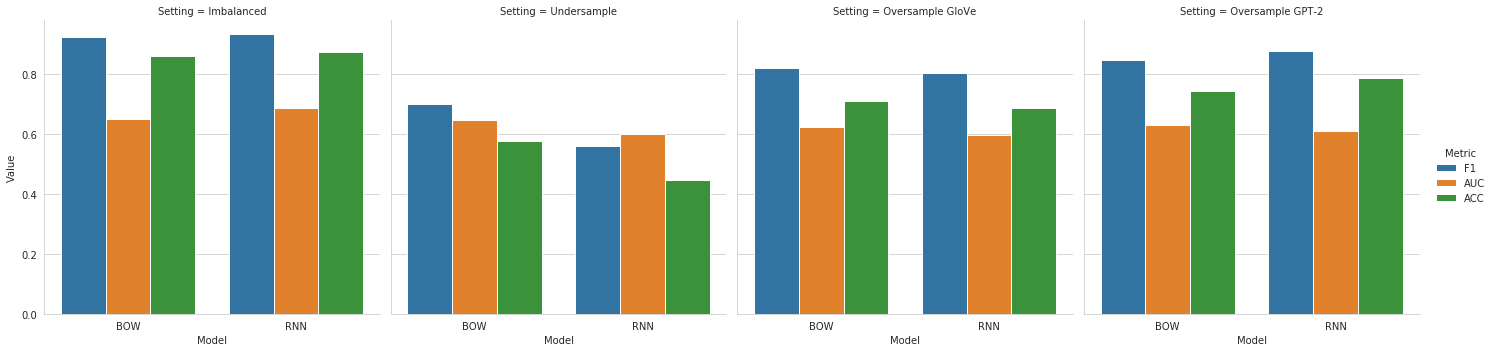

In [0]:
#barplot 1
sns.catplot(x="Model", y="Value", hue="Metric", col="Setting", data=results_df, kind="bar", ci=None);

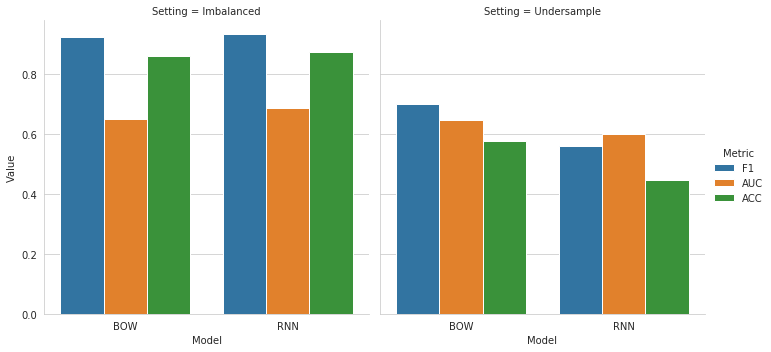

In [0]:
#barplot 2
sns.catplot(x="Model", y="Value", hue="Metric", col="Setting", data=results_df1, kind="bar", ci=None);

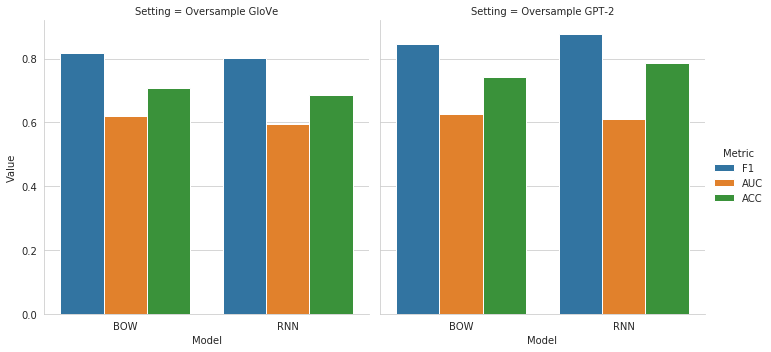

In [0]:
#barplot 3
sns.catplot(x="Model", y="Value", hue="Metric", col="Setting", data=results_df2, kind="bar", ci=None);

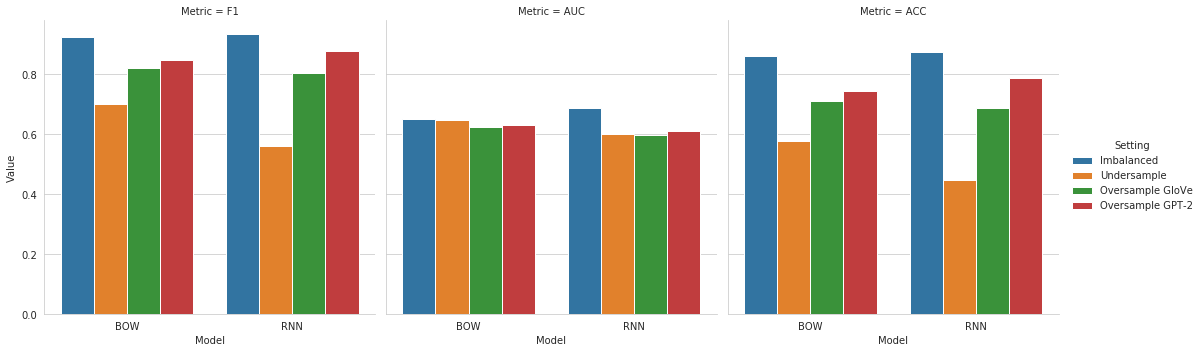

In [0]:
#barplot 4
sns.catplot(x="Model", y="Value", hue="Setting", col="Metric", data=results_df, kind="bar", ci=None);

### Confusion Matrices

In [0]:
#make list of all confusion matrices
cm_list = [confusion_matrix_bow_imbalanced, confusion_matrix_rnn_imbalanced, 
           confusion_matrix_bow_undersample, confusion_matrix_rnn_undersample,
           confusion_matrix_bow_oversample_glove, confusion_matrix_rnn_oversample_glove,
           confusion_matrix_bow_oversample_gpt2, confusion_matrix_rnn_oversample_gpt2]

#prepare dataframe for values of confusion matrices
cm_values_df = pd.DataFrame(columns = ['TP', 'TN', 'FP', 'FN'])
cm_values_df

cm_list[1]

Predicted,0,1
True,,
0,99,6323
1,101,43477


In [0]:
#prepare lists for values
tp = list()
tn = list()
fp = list()
fn = list()

#extrct values form all confusion matrices
for cm in cm_list:
    tp.append(cm[1][1])
    tn.append(cm[0][0])
    fp.append(cm[1][0])
    fn.append(cm[0][1])

#put values into prepared dataframe
cm_values_df.TP = tp
cm_values_df.TN = tn
cm_values_df.FP = fp
cm_values_df.FN = fn

#filling additional columns
cm_values_df['Model'] = ['BOW', 'RNN', 'BOW', 'RNN', 'BOW', 'RNN', 'BOW', 'RNN']
cm_values_df['Setting'] = ['Imbalanced', 'Imbalanced', 'Undersample', 'Undersample', 
                           'Oversample GloVe', 'Oversample GloVe', 'Oversample GPT-2', 'Oversample GPT-2']

print(cm_values_df)
print(confusion_matrix_bow_imbalanced)

      TP    TN    FP     FN Model           Setting
0  42412   466  5956   1166   BOW        Imbalanced
1  43477    99  6323    101   RNN        Imbalanced
2  24700  4149  2273  18878   BOW       Undersample
3  17638  4699  1723  25940   RNN       Undersample
4  32831  2555  3867  10747   BOW  Oversample GloVe
5  31782  2497  3925  11796   RNN  Oversample GloVe
6  35043  2136  4286   8535   BOW  Oversample GPT-2
7  37870  1390  5032   5708   RNN  Oversample GPT-2
Predicted     0      1
True                  
0           466   5956
1          1166  42412


In [0]:
#melt dataframe to reach necessary dataframe format
melted_df = pd.melt(cm_values_df, 
                    id_vars=["Model", "Setting"], # Variables to keep
                    var_name="CM_Values") # Name of melted variable
melted_df.head()

,Model,Setting,CM_Values,value
0,BOW,Imbalanced,TP,42412
1,RNN,Imbalanced,TP,43477
2,BOW,Undersample,TP,24700
3,RNN,Undersample,TP,17638
4,BOW,Oversample GloVe,TP,32831


In [0]:
print(cm_values_df.shape)
print(melted_df.shape)

(8, 6)
(32, 4)


In [0]:
#setting figure size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

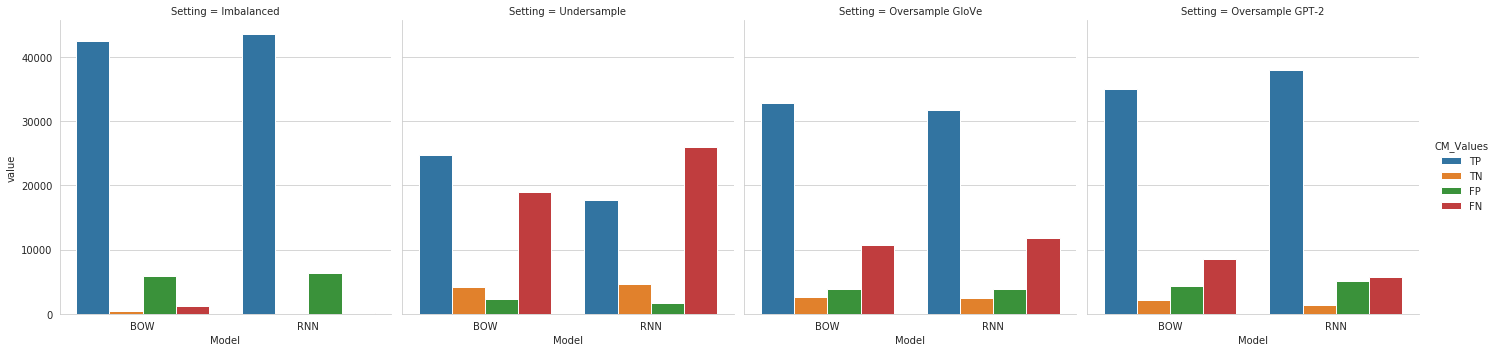

In [0]:
#barplot 1
sns.catplot(x="Model", y="value", hue="CM_Values", col="Setting", data=melted_df, kind="bar", ci=None);

In [0]:
#calculate percentages (rates)
melted_df['Rate'] = melted_df['value']/len(text_classification_test_reduced)
melted_df.head()

,Model,Setting,CM_Values,value,Rate
0,BOW,Imbalanced,TP,42412,0.84824
1,RNN,Imbalanced,TP,43477,0.86954
2,BOW,Undersample,TP,24700,0.49400
3,RNN,Undersample,TP,17638,0.35276
4,BOW,Oversample GloVe,TP,32831,0.65662


In [0]:
#Stacked Bar Plot Percentage
pivot_df_bow = melted_df[melted_df['Model'] == 'BOW'].pivot(index='Setting', columns='CM_Values', values='Rate')
print(pivot_df_bow)

pivot_df_rnn = melted_df[melted_df['Model'] == 'RNN'].pivot(index='Setting', columns='CM_Values', values='Rate')
print(pivot_df_rnn)

CM_Values              FN       FP       TN       TP
Setting                                             
Imbalanced        0.02332  0.11912  0.00932  0.84824
Oversample GPT-2  0.17070  0.08572  0.04272  0.70086
Oversample GloVe  0.21494  0.07734  0.05110  0.65662
Undersample       0.37756  0.04546  0.08298  0.49400
CM_Values              FN       FP       TN       TP
Setting                                             
Imbalanced        0.00202  0.12646  0.00198  0.86954
Oversample GPT-2  0.11416  0.10064  0.02780  0.75740
Oversample GloVe  0.23592  0.07850  0.04994  0.63564
Undersample       0.51880  0.03446  0.09398  0.35276


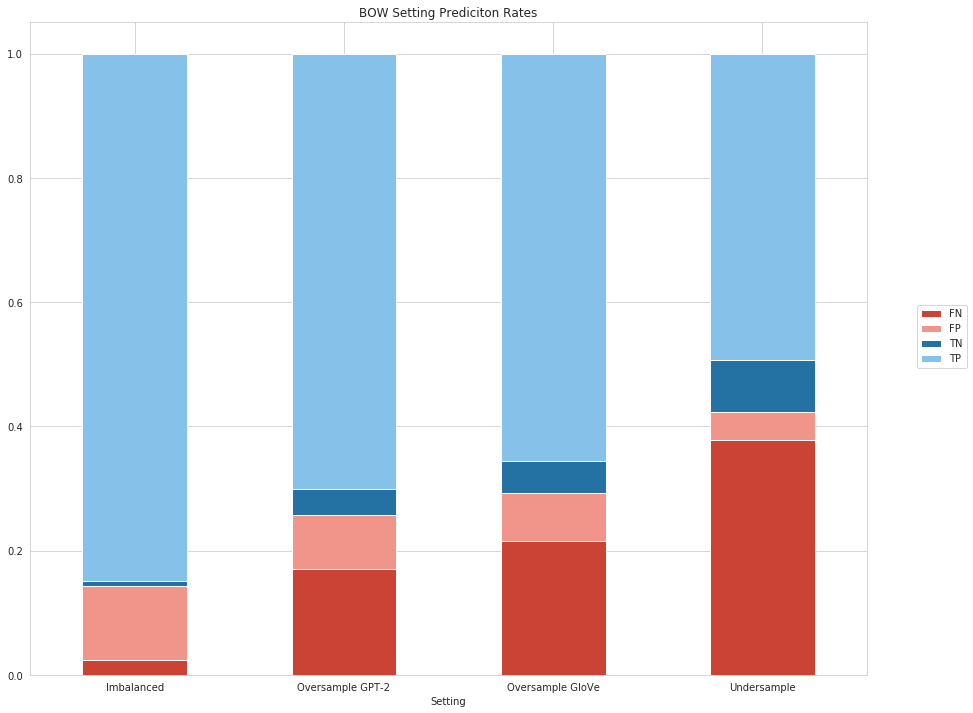

In [0]:
#setting colors of stacked bars
colors = ["#CB4335", "#F1948A","#2471A3", '#85C1E9']

#construct pivot dataframe and plot
pivot_df_bow.loc[:,['FN', 'FP', 'TN', 'TP']].plot.bar(stacked=True, color=colors, figsize=(15,12), title = 'BOW Setting Prediciton Rates', rot = 0).legend(bbox_to_anchor=(1.125, 0.575))

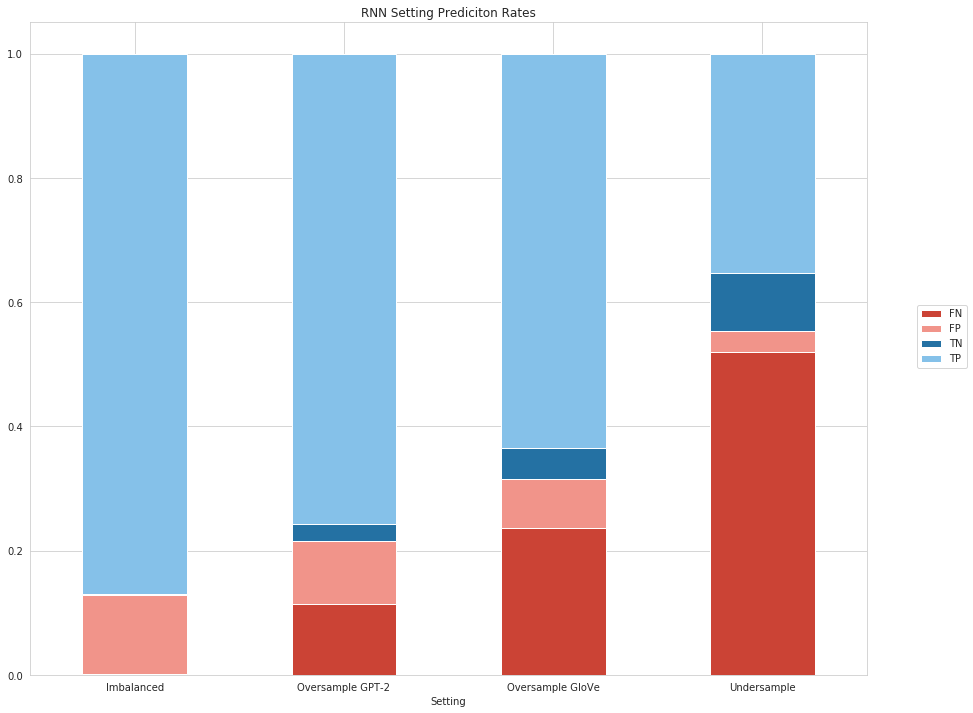

In [0]:
#set colors
colors = ["#CB4335", "#F1948A","#2471A3", '#85C1E9']

#construct pivot dataframe
pivot_df_rnn.loc[:,['FN', 'FP', 'TN', 'TP']].plot.bar(stacked=True, color=colors, figsize=(15,12), title = 'RNN Setting Prediciton Rates', rot = 0).legend(bbox_to_anchor=(1.125, 0.575))

## Including "Not-Sure"-Category

In [0]:
pred_df.head()

,bow_imbalanced,rnn_imbalanced,bow_undersample,rnn_undersample,bow_glove,rnn_glove,bow_gpt2,rnn_gpt2,true_value
0,0.671189,0.671189,0.001569,0.224269,0.014440,0.267475,0.006568,0.048076,1
1,0.986998,0.986998,0.977082,0.698867,0.961582,0.619096,0.999947,0.951166,1
2,0.804610,0.804610,0.394534,0.379952,0.419384,0.789161,0.473426,0.583110,1
3,0.728797,0.728797,0.562474,0.370842,0.812884,0.881891,0.710474,0.720110,0
4,0.946659,0.946659,0.828682,0.385463,0.744797,0.262660,0.949494,0.889298,1


In [0]:
#setting thresholds for 'not-sure'-category
threshold1 = 0.4
threshold2 = 0.6

#find row indices to remove
drop_idx = pred_df['rnn_gpt2'][pred_df.rnn_gpt2.between(threshold1, threshold2)].index

# remove predictions that lie in between thresholds
pred_df_reduced = pred_df.drop(drop_idx)
pred_df_reduced = pred_df_reduced[['rnn_gpt2', 'true_value']]

#convert probabilities of reduced predictions dataframe to classes
pred_df_reduced_class = class_prediction(list(pred_df_reduced['rnn_gpt2']))
pred_df_reduced_class['true_value'] = list(pred_df_reduced.true_value)

#confusion matrix
confusion_matrix_rnn_gpt2_thresholds = conf_matrix(pred_df_reduced_class['class_pred'], pred_df_reduced_class['true_value'])
print(confusion_matrix_rnn_gpt2_thresholds)

#evaluation metrics
import sklearn

#claculate evaluation metrics
f1_rnn_gpt2_thresholds = sklearn.metrics.f1_score(pred_df_reduced_class['true_value'],pred_df_reduced_class['class_pred'])
auc_rnn_gpt2_thresholds = sklearn.metrics.roc_auc_score(pred_df_reduced_class['true_value'],pred_df_reduced_class['class_pred'])
acc_rnn_gpt2_thresholds = sklearn.metrics.accuracy_score(pred_df_reduced_class['true_value'],pred_df_reduced_class['class_pred'])

print("F1:", f1_rnn_gpt2_thresholds)
print("AUC:", auc_rnn_gpt2_thresholds)
print("ACC:", acc_rnn_gpt2_thresholds)

50000
3647
Predicted     0      1
True                  
0          1083   4685
1          4343  36242
F1: 0.8892433015997645
AUC: 0.5403750382111002
ACC: 0.8052337497033634


### Compare Results with and without "Not-Sure"-Category

In [0]:
#print results of both scenarios
print("F1 all:", f1_rnn_oversample_gpt2)
print("F1 not sure:", f1_rnn_gpt2_thresholds, "\n")

print("AUC all:", auc_rnn_oversample_gpt2)
print("AUC not sure:", auc_rnn_gpt2_thresholds, "\n")

print("ACC all:", acc_rnn_oversample_gpt2)
print("ACC not sure:", acc_rnn_gpt2_thresholds, "\n")

F1 all: 0.8758094357076781
F1 not sure: 0.8892433015997645 

AUC all: 0.6090585356177668
AUC not sure: 0.5403750382111002 

ACC all: 0.7852
ACC not sure: 0.8052337497033634 



In [0]:
#print additional information
print("Comments to check manually:", len(pred_df) - len(pred_df_reduced_class))
print("Number of total comments:", len(pred_df))
print("Precetage of comments removed", (len(pred_df) - len(pred_df_reduced_class))/len(pred_df))

Comments to check manually: 3647
Number of total comments: 50000
Precetage of comments removed 0.07294


In [0]:
#compare confusion matrices
print(confusion_matrix_rnn_oversample_gpt2)
print(confusion_matrix_rnn_gpt2_thresholds)

Predicted     0      1
True                  
0          1390   5032
1          5708  37870
Predicted     0      1
True                  
0          1083   4685
1          4343  36242


##### Visualize Results of including "Not Sure"-Category 

In [0]:
#prepare dataframe to visualize results
cm_values_not_sure_df = pd.DataFrame({'Value':[confusion_matrix_rnn_oversample_gpt2[0][0], confusion_matrix_rnn_gpt2_thresholds[0][0],
                                               confusion_matrix_rnn_oversample_gpt2[1][1], confusion_matrix_rnn_gpt2_thresholds[1][1],
                                               confusion_matrix_rnn_oversample_gpt2[1][0], confusion_matrix_rnn_gpt2_thresholds[1][0],
                                               confusion_matrix_rnn_oversample_gpt2[0][1], confusion_matrix_rnn_gpt2_thresholds[0][1]],
                                      'Measure':['TN', 'TN', 'TP', 'TP', 'FN', 'FN', 'FP', 'FP'],
                                      'Setting': ['Oversampling GPT-2', 'Oversampling GPT-2 Not Sure', 'Oversampling GPT-2', 'Oversampling GPT-2 Not Sure', 
                                                  'Oversampling GPT-2', 'Oversampling GPT-2 Not Sure', 'Oversampling GPT-2', 'Oversampling GPT-2 Not Sure'],
                                      'Model':['RNN', 'RNN', 'RNN', 'RNN', 'RNN', 'RNN', 'RNN', 'RNN']})

cm_values_not_sure_df.head()

,Value,Measure,Setting,Model
0,1390,TN,Oversampling GPT-2,RNN
1,1083,TN,Oversampling GPT-2 Not Sure,RNN
2,37870,TP,Oversampling GPT-2,RNN
3,36242,TP,Oversampling GPT-2 Not Sure,RNN
4,5032,FN,Oversampling GPT-2,RNN


In [0]:
#setting figure size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

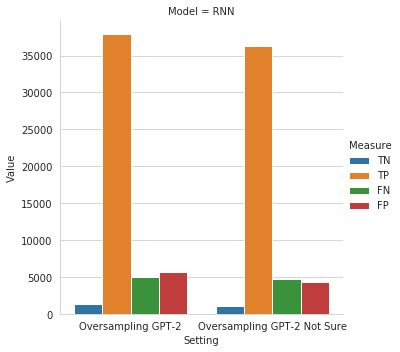

In [0]:
#barplot 1
sns.catplot(x="Setting", y="Value", hue="Measure", col="Model", data=cm_values_not_sure_df, kind="bar", ci=None);

##### Stacked Percentage Bar Plot

In [0]:
#prepare dataframe for stacked barplot
#filter dataframe based on setting to construct two separate ones
cm_values_not_sure_df1 = cm_values_not_sure_df[cm_values_not_sure_df['Setting'] == 'Oversampling GPT-2']
cm_values_not_sure_df2 = cm_values_not_sure_df[cm_values_not_sure_df['Setting'] == 'Oversampling GPT-2 Not Sure']

#calculate percentages of values
cm_values_not_sure_df1['Rate'] = cm_values_not_sure_df1['Value']/len(pred_df)
cm_values_not_sure_df2['Rate'] = cm_values_not_sure_df2['Value']/len(pred_df_reduced)

print(cm_values_not_sure_df1.head())
print(cm_values_not_sure_df2.head())

cm_values_not_sure_df = pd.concat([cm_values_not_sure_df1, cm_values_not_sure_df2])
cm_values_not_sure_df.head()

   Value Measure             Setting Model     Rate
0   1390      TN  Oversampling GPT-2   RNN  0.02780
2  37870      TP  Oversampling GPT-2   RNN  0.75740
4   5032      FN  Oversampling GPT-2   RNN  0.10064
6   5708      FP  Oversampling GPT-2   RNN  0.11416
   Value Measure                      Setting Model      Rate
1   1083      TN  Oversampling GPT-2 Not Sure   RNN  0.023364
3  36242      TP  Oversampling GPT-2 Not Sure   RNN  0.781870
5   4685      FN  Oversampling GPT-2 Not Sure   RNN  0.101072
7   4343      FP  Oversampling GPT-2 Not Sure   RNN  0.093694


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Value,Measure,Setting,Model,Rate
0,1390,TN,Oversampling GPT-2,RNN,0.027800
2,37870,TP,Oversampling GPT-2,RNN,0.757400
4,5032,FN,Oversampling GPT-2,RNN,0.100640
6,5708,FP,Oversampling GPT-2,RNN,0.114160
1,1083,TN,Oversampling GPT-2 Not Sure,RNN,0.023364


In [0]:
#Stacked Bar Plot Percentage
pivot_df_bow = cm_values_not_sure_df[cm_values_not_sure_df['Model'] == 'RNN'].pivot(index='Setting', columns='Measure', values='Rate')
print(pivot_df_bow)

Measure                            FN        FP        TN       TP
Setting                                                           
Oversampling GPT-2           0.100640  0.114160  0.027800  0.75740
Oversampling GPT-2 Not Sure  0.101072  0.093694  0.023364  0.78187


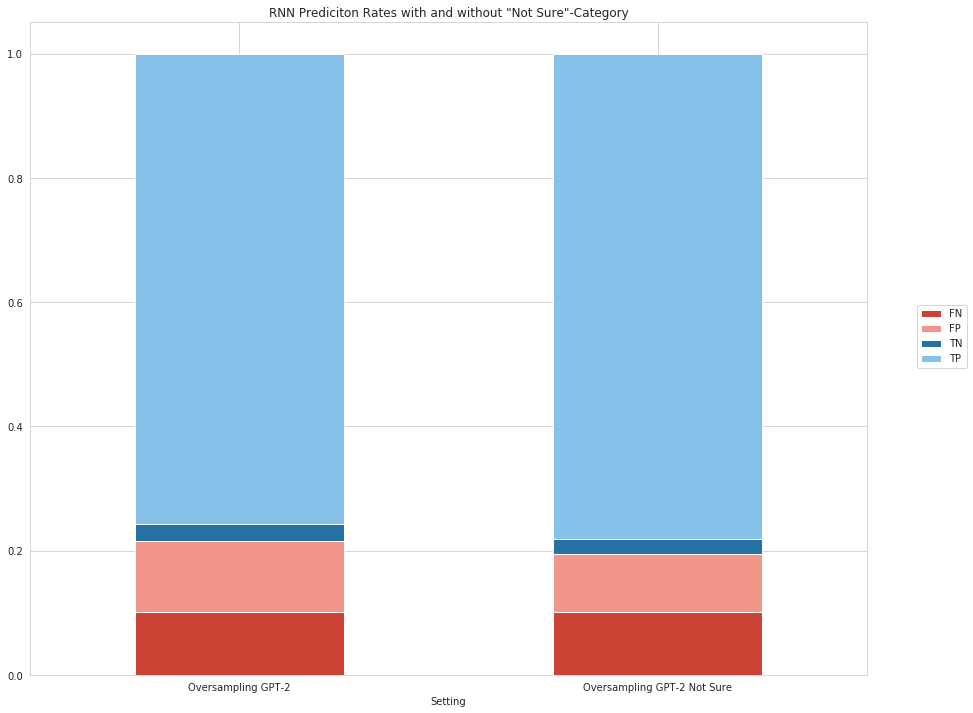

In [0]:
#setting colors
colors = ["#CB4335", "#F1948A","#2471A3", '#85C1E9']

#construct and plot pivot dataframe
pivot_df_bow.loc[:,['FN', 'FP', 'TN', 'TP']].plot.bar(stacked=True, color=colors, figsize=(15,12), title = 'RNN Prediciton Rates with and without "Not Sure"-Category', rot = 0).legend(bbox_to_anchor=(1.125, 0.575))

#### Distribution of Predicted Probabilities

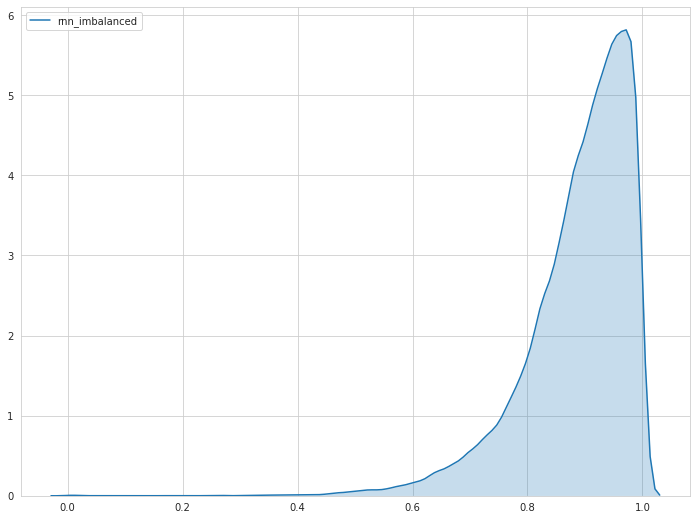

In [0]:
#plot distribution of predicted probabilities
sns.kdeplot(pred_df['rnn_imbalanced'], shade=True);

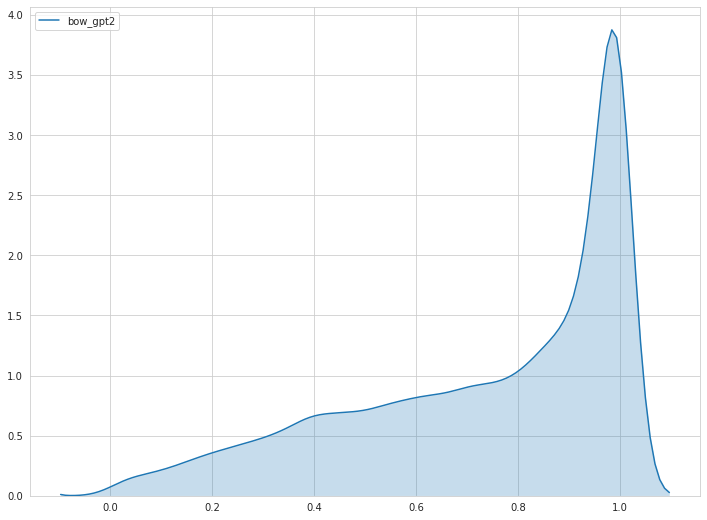

In [0]:
#plot distribution of predicted probabilities
sns.kdeplot(pred_df['bow_gpt2'], shade=True);

## Try different balancing Ratios for generated Comments

In [0]:
print(len(text_classification_train_reduced))
print(len(text_classification_train_reduced[text_classification_train_reduced['published'] == True]))

#percentage of published comments
perc_published = len(text_classification_train_reduced[text_classification_train_reduced['published'] == True])/len(text_classification_train_reduced)
print(perc_published)


146292
127039
0.86839335028573


In [0]:
#generated glove comments
glove_gen_comments.head()

,text,online
0,sozialforschung hinzu koran nicht buergermeist...,False
1,sollen steht immer verlieren ja dafuer moege t...,False
2,integrationsbeauftragte region nicht lauter ei...,False
3,laberwerkstatt blauen unglaeubigen irrtum lueg...,False
4,parteien links afd ruegt loew freiheit hoelle ...,False


### 50:50 Balancing

In [0]:
#number of comments necessary for specified balancing
print(len(text_classification_train_reduced[text_classification_train_reduced['published'] == True]) - len(text_classification_train_reduced[text_classification_train_reduced['published'] == False]))

107786


In [0]:
#results from 50:50 balancing
print("F1 BOW:", f1_bow_oversample_glove)
print("F1 RNN:", f1_rnn_oversample_glove, "\n")
print("AUC BOW:", auc_bow_oversample_glove)
print("AUC RNN:", auc_rnn_oversample_glove, "\n")
print("ACC BOW:", acc_bow_oversample_glove)
print("ACC RNN:", acc_rnn_oversample_glove, "\n")
print(confusion_matrix_bow_imbalanced, "\n")
print(confusion_matrix_rnn_imbalanced, "\n")

F1 BOW: 0.8179530619363197
F1 RNN: 0.8017153307687457 

AUC BOW: 0.6213615251104778
AUC RNN: 0.5958927458031953 

ACC BOW: 0.70772
ACC RNN: 0.68558 

Predicted     0      1
True                  
0           466   5956
1          1166  42412 

Predicted    0      1
True                 
0           99   6323
1          101  43477 



### Different Ratios

In [0]:
#number of generated comments used in 50:50 balancing
glove_comments_5050 = len(glove_gen_comments)

#reduced number of generated comments
glove_comments_ratio1 = int(0.5*glove_comments_5050)
glove_comments_ratio2 = int(0.5*glove_comments_ratio1)

print("All Comments Used:", glove_comments_5050)
print("Reduced Comments Ratio 1:", glove_comments_ratio1)
print("Reduced Comments Ratio 2:", glove_comments_ratio2)

All Comments Used: 30133
Reduced Comments Ratio 1: 15066
Reduced Comments Ratio 2: 7533


#### Ratio 1

In [0]:
#take sample of glove generated comments
glove_gen_comments_ratio1 = glove_gen_comments.sample(n=glove_comments_ratio1, random_state=1)
glove_gen_comments_ratio1.head()

,text,online
5690,twitter nazikeule eu sonne hinderlich rede deu...,False
19778,schaden nichts themen hoechsten aufgerufen umh...,False
28757,schon idee tuerkei kasse geringsten meisten de...,False
27047,dabei anmassend aktivistin aerzte gepredigt ni...,False
29804,keinen gegensatz songs untermauert erst glaube...,False


##### Extending original Data Set with generated comments

In [0]:
#adding generated comments to original data
df_gen_glove_ratio1 = text_classification_train_reduced_small_glove[['text', 'published']].copy()
df_gen_glove_ratio1.head()

,text,online
1236267,erlauben stamp kannte mann bisher nicht,False
722238,glaube sahara gibt s genug,True
312585,zunaechst vielen dank georg differenzierten kl...,True
1334051,filiz message verstanden suedliche server weit...,False
531370,dafuer ausfuehrlich lesen seibert denkt fuehlt,False


In [0]:
#extension dataframe
glove_gen_ext_ratio1 = pd.DataFrame(glove_gen_comments_ratio1)
glove_gen_ext_ratio1['published'] = False
glove_gen_ext_ratio1.head()

,text,online
5690,twitter nazikeule eu sonne hinderlich rede deu...,False
19778,schaden nichts themen hoechsten aufgerufen umh...,False
28757,schon idee tuerkei kasse geringsten meisten de...,False
27047,dabei anmassend aktivistin aerzte gepredigt ni...,False
29804,keinen gegensatz songs untermauert erst glaube...,False


In [0]:
#concatenating data frames
df_gen_glove_ratio1 = pd.concat([df_gen_glove_ratio1, glove_gen_ext_ratio1])
len(df_gen_glove_ratio1)

59148

In [0]:
#check balancedness
df_gen_glove_ratio1['published'].value_counts()

True     38195
False    20953
Name: online, dtype: int64

In [0]:
#percentage of published comments
perc_published = len(df_gen_glove_ratio1[df_gen_glove_ratio1['published'] == True])/len(df_gen_glove_ratio1)
print(perc_published)

0.6457530263068912


##### Classification with balanced Dataset using GloVe Comments

In [0]:
#extracting texts and labels from data frame
comment = pd.DataFrame()

comment['text'] = df_gen_glove_ratio1['text']
comment['label'] = df_gen_glove_ratio1['published']

comment.head()

,text,label
1236267,erlauben stamp kannte mann bisher nicht,False
722238,glaube sahara gibt s genug,True
312585,zunaechst vielen dank georg differenzierten kl...,True
1334051,filiz message verstanden suedliche server weit...,False
531370,dafuer ausfuehrlich lesen seibert denkt fuehlt,False


In [0]:
#prepare training set
comment_train = comment['text']
label_train = comment['label']

In [0]:
print(comment_train.shape)
print(comment_test.shape)
print(label_train.shape)
print(label_test.shape)

(59148,)
(50000,)
(59148,)
(50000,)


##### BOW Classifier

In [0]:
#bag of words classification
pred_bow_oversample_glove_ratio1 = bow_classification(comment_train=comment_train, comment_test=comment_test)

##### Calculate Evaluation Metrics

In [0]:
#calculate class predictions
pred_bow_oversample_glove_ratio1_class = class_prediction(pred_bow_oversample_glove_ratio1)

In [0]:
#construct confusion matrix
confusion_matrix_bow_oversample_glove_ratio1 = conf_matrix(pred_bow_oversample_glove_ratio1_class['class_pred'], text_classification_test_reduced.published)
print(confusion_matrix_bow_oversample_glove_ratio1)

Predicted     0      1
True                  
0          1558   4864
1          6052  37526


##### Evaluation Metrics: F1, AUC, ACC

In [0]:
import sklearn

#calculate evaluation metrics
f1_bow_oversample_glove_ratio1 = sklearn.metrics.f1_score(text_classification_test_reduced.published, pred_bow_oversample_glove_ratio1_class.class_pred)
auc_bow_oversample_glove_ratio1 = sklearn.metrics.roc_auc_score(text_classification_test_reduced.published, pred_bow_oversample_glove_ratio1_class.prob_pred)
acc_bow_oversample_glove_ratio1 = sklearn.metrics.accuracy_score(text_classification_test_reduced.published, pred_bow_oversample_glove_ratio1_class.class_pred)

print("F1:", f1_bow_oversample_glove_ratio1)
print("AUC:", auc_bow_oversample_glove_ratio1)
print("ACC:", acc_bow_oversample_glove_ratio1)

F1: 0.8730225200074446
AUC: 0.624903806544461
ACC: 0.78168


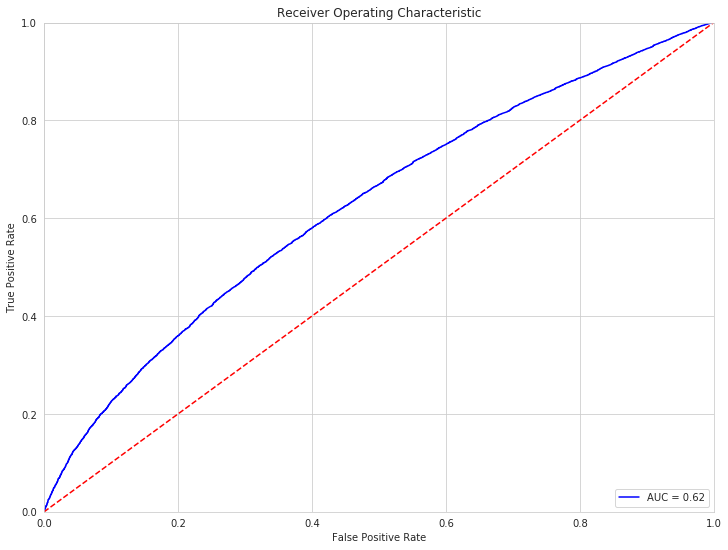

In [0]:
#plot roc-auc curve
plot_roc_auc(text_classification_test_reduced.published, pred_bow_oversample_glove_ratio1_class.prob_pred)

##### Preparation for RNN Classifier

In [0]:
#tokenization and padding of sequences
X_train, X_test = prepare_data_rnn(comment_train, comment_test)

##### RNN - Classifier

In [0]:
#setting early stopping parameter
ea = EarlyStopping(monitor="val_loss", mode="min", patience=5)

#train RNN model
model.fit(X_train, label_train,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, label_test),
          callbacks=[ea],
          batch_size=BATCH_SIZE)

Train on 59148 samples, validate on 50000 samples
Epoch 1/20
59148/59148 [==============================] - 37s 624us/step - loss: 0.6522 - acc: 0.6430 - val_loss: 0.5164 - val_acc: 0.8612
Epoch 2/20
59148/59148 [==============================] - 37s 619us/step - loss: 0.5985 - acc: 0.6767 - val_loss: 0.4827 - val_acc: 0.8440
Epoch 3/20
59148/59148 [==============================] - 36s 609us/step - loss: 0.5718 - acc: 0.6957 - val_loss: 0.4948 - val_acc: 0.8311
Epoch 4/20
59148/59148 [==============================] - 36s 602us/step - loss: 0.5559 - acc: 0.7110 - val_loss: 0.4762 - val_acc: 0.8348
Epoch 5/20
59148/59148 [==============================] - 35s 599us/step - loss: 0.5424 - acc: 0.7208 - val_loss: 0.4984 - val_acc: 0.8050
Epoch 6/20
59148/59148 [==============================] - 36s 614us/step - loss: 0.5289 - acc: 0.7315 - val_loss: 0.4873 - val_acc: 0.8113
Epoch 7/20
59148/59148 [==============================] - 36s 601us/step - loss: 0.5187 - acc: 0.7389 - val_loss: 0.

In [0]:
#predict class probabilities
pred_rnn_oversample_glove_ratio1 = model.predict(X_test)

##### Calculate Evaluation Metrics

In [0]:
#calculate class predictions
pred_rnn_oversample_glove_ratio1_class = class_prediction(pred_rnn_oversample_glove_ratio1)

##### Confusion Matrix

In [0]:
#construct confusion matrix
confusion_matrix_rnn_oversample_glove_ratio1 = conf_matrix(pred_rnn_oversample_glove_ratio1_class['class_pred'], text_classification_test_reduced.published)
print(confusion_matrix_rnn_oversample_glove_ratio1)

Predicted     0      1
True                  
0          1101   5321
1          4689  38889


##### Evaluation Metrics: F1, AUC, ACC

In [0]:
import sklearn

#calculate evaluation metrics
f1_rnn_oversample_glove_ratio1 = sklearn.metrics.f1_score(text_classification_test_reduced.published, pred_rnn_oversample_glove_ratio1_class.class_pred)
auc_rnn_oversample_glove_ratio1 = sklearn.metrics.roc_auc_score(text_classification_test_reduced.published, pred_rnn_oversample_glove_ratio1_class.prob_pred)
acc_rnn_oversample_glove_ratio1 = sklearn.metrics.accuracy_score(text_classification_test_reduced.published, pred_rnn_oversample_glove_ratio1_class.class_pred)

print("F1:", f1_rnn_oversample_glove_ratio1)
print("AUC:", auc_rnn_oversample_glove_ratio1)
print("ACC:", acc_rnn_oversample_glove_ratio1)

F1: 0.8859753041417963
AUC: 0.5856981744264829
ACC: 0.7998


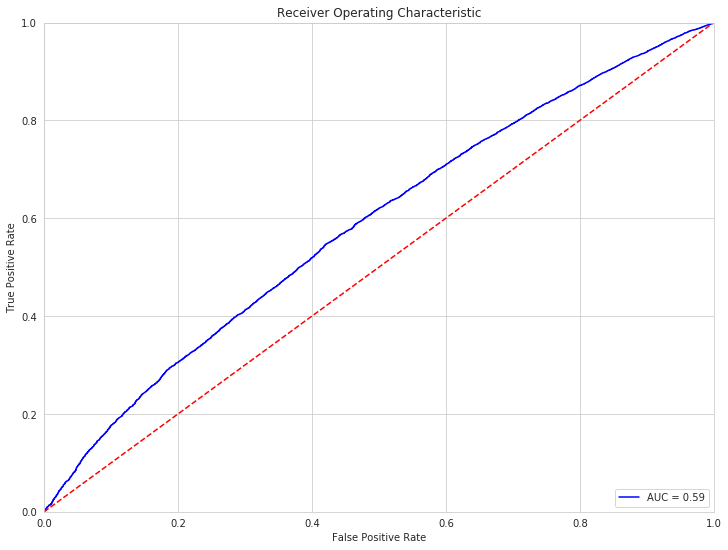

In [0]:
#plot roc-auc curves
plot_roc_auc(text_classification_test_reduced.published, pred_rnn_oversample_glove_ratio1_class.prob_pred)

In [0]:
#print results for both models
print("F1 BOW Oversampled Glove:", f1_bow_oversample_glove_ratio1)
print("F1 RNN Oversampled Glove:", f1_rnn_oversample_glove_ratio1)

print("AUC BOW Oversampled Glove:", auc_bow_oversample_glove_ratio1)
print("AUC RNN Oversampled Glove:", auc_rnn_oversample_glove_ratio1)

print("ACC BOW Oversampled Glove:", acc_bow_oversample_glove_ratio1)
print("ACC RNN Oversampled Glove:", acc_rnn_oversample_glove_ratio1)

F1 BOW Oversampled Glove: 0.8730225200074446
F1 RNN Oversampled Glove: 0.8859753041417963
AUC BOW Oversampled Glove: 0.624903806544461
AUC RNN Oversampled Glove: 0.5856981744264829
ACC BOW Oversampled Glove: 0.78168
ACC RNN Oversampled Glove: 0.7998


#### Ratio 2

In [0]:
#take sample of glove generated comments
glove_gen_comments_ratio2 = glove_gen_comments.sample(n=glove_comments_ratio2, random_state=1)
glove_gen_comments_ratio2.head()

,text,online
5690,twitter nazikeule eu sonne hinderlich rede deu...,False
19778,schaden nichts themen hoechsten aufgerufen umh...,False
28757,schon idee tuerkei kasse geringsten meisten de...,False
27047,dabei anmassend aktivistin aerzte gepredigt ni...,False
29804,keinen gegensatz songs untermauert erst glaube...,False


##### Extending original Data Set with generated comments

In [0]:
#adding generated comments to original data
df_gen_glove_ratio2 = text_classification_train_reduced_small_glove[['text', 'published']].copy()
df_gen_glove_ratio2.head()

,text,online
1236267,erlauben stamp kannte mann bisher nicht,False
722238,glaube sahara gibt s genug,True
312585,zunaechst vielen dank georg differenzierten kl...,True
1334051,filiz message verstanden suedliche server weit...,False
531370,dafuer ausfuehrlich lesen seibert denkt fuehlt,False


In [0]:
#extension dataframe
glove_gen_ext_ratio2 = pd.DataFrame(glove_gen_comments_ratio2)
glove_gen_ext_ratio2['published'] = False
glove_gen_ext_ratio2.head()

,text,online
5690,twitter nazikeule eu sonne hinderlich rede deu...,False
19778,schaden nichts themen hoechsten aufgerufen umh...,False
28757,schon idee tuerkei kasse geringsten meisten de...,False
27047,dabei anmassend aktivistin aerzte gepredigt ni...,False
29804,keinen gegensatz songs untermauert erst glaube...,False


In [0]:
#concatenating data frames
df_gen_glove_ratio2 = pd.concat([df_gen_glove_ratio2, glove_gen_ext_ratio2])
len(df_gen_glove_ratio2)

51615

In [0]:
#check balancedness
df_gen_glove_ratio2['published'].value_counts()

True     38195
False    13420
Name: online, dtype: int64

In [0]:
#percentage of published comments
perc_published = len(df_gen_glove_ratio2[df_gen_glove_ratio2['published'] == True])/len(df_gen_glove_ratio2)
print(perc_published)

0.7399980625787077


##### Classification with balanced Dataset using GloVe Comments

In [0]:
#extracting texts and labels from data frame
comment = pd.DataFrame()

comment['text'] = df_gen_glove_ratio2['text']
comment['label'] = df_gen_glove_ratio2['published']

comment.head()

,text,label
1236267,erlauben stamp kannte mann bisher nicht,False
722238,glaube sahara gibt s genug,True
312585,zunaechst vielen dank georg differenzierten kl...,True
1334051,filiz message verstanden suedliche server weit...,False
531370,dafuer ausfuehrlich lesen seibert denkt fuehlt,False


In [0]:
#prepare training set
comment_train = comment['text']
label_train = comment['label']

In [0]:
print(comment_train.shape)
print(comment_test.shape)
print(label_train.shape)
print(label_test.shape)

(51615,)
(50000,)
(51615,)
(50000,)


##### BOW Classifier

In [0]:
#bag of words classification
pred_bow_oversample_glove_ratio2 = bow_classification(comment_train=comment_train, comment_test=comment_test)

##### Calculate Evaluation Metrics

In [0]:
#calculate class predictions
pred_bow_oversample_glove_ratio2_class = class_prediction(pred_bow_oversample_glove_ratio2)

In [0]:
#construcs confusion matrix
confusion_matrix_bow_oversample_glove_ratio2 = conf_matrix(pred_bow_oversample_glove_ratio2_class['class_pred'], text_classification_test_reduced.published)
print(confusion_matrix_bow_oversample_glove_ratio2)

Predicted     0      1
True                  
0          1007   5415
1          3533  40045


##### Evaluation Metrics: F1, AUC, ACC

In [0]:
import sklearn

#calculate evaluation metrics
f1_bow_oversample_glove_ratio2 = sklearn.metrics.f1_score(text_classification_test_reduced.published, pred_bow_oversample_glove_ratio2_class.class_pred)
auc_bow_oversample_glove_ratio2 = sklearn.metrics.roc_auc_score(text_classification_test_reduced.published, pred_bow_oversample_glove_ratio2_class.prob_pred)
acc_bow_oversample_glove_ratio2 = sklearn.metrics.accuracy_score(text_classification_test_reduced.published, pred_bow_oversample_glove_ratio2_class.class_pred)

print("F1:", f1_bow_oversample_glove_ratio2)
print("AUC:", auc_bow_oversample_glove_ratio2)
print("ACC:", acc_bow_oversample_glove_ratio2)

F1: 0.8995035827399539
AUC: 0.6278661794222751
ACC: 0.82104


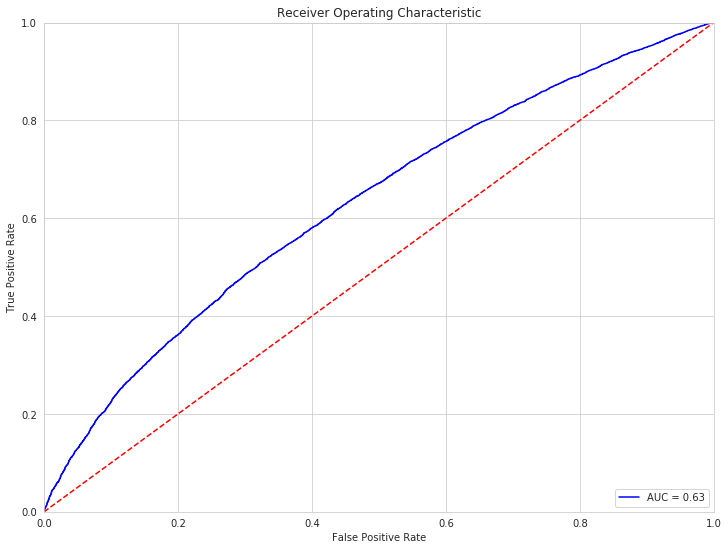

In [0]:
#plot roc-auc curve
plot_roc_auc(text_classification_test_reduced.published, pred_bow_oversample_glove_ratio2_class.prob_pred)

##### Preparation for RNN Classifier

In [0]:
#tokenization and padding of sequences
X_train, X_test = prepare_data_rnn(comment_train, comment_test)

##### RNN - Classifier

In [0]:
#setting early stopping parameter
ea = EarlyStopping(monitor="val_loss", mode="min", patience=5)

#train RNN model
model.fit(X_train, label_train,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(X_test, label_test),
          callbacks=[ea],
          batch_size=BATCH_SIZE)

Train on 51615 samples, validate on 50000 samples
Epoch 1/20
51615/51615 [==============================] - 32s 620us/step - loss: 0.5738 - acc: 0.7343 - val_loss: 0.4477 - val_acc: 0.8704
Epoch 2/20
51615/51615 [==============================] - 32s 627us/step - loss: 0.5517 - acc: 0.7405 - val_loss: 0.4420 - val_acc: 0.8684
Epoch 3/20
51615/51615 [==============================] - 32s 619us/step - loss: 0.5359 - acc: 0.7506 - val_loss: 0.4345 - val_acc: 0.8621
Epoch 4/20
51615/51615 [==============================] - 32s 623us/step - loss: 0.5168 - acc: 0.7628 - val_loss: 0.4226 - val_acc: 0.8640
Epoch 5/20
51615/51615 [==============================] - 32s 612us/step - loss: 0.5015 - acc: 0.7717 - val_loss: 0.4258 - val_acc: 0.8589
Epoch 6/20
51615/51615 [==============================] - 32s 617us/step - loss: 0.4917 - acc: 0.7774 - val_loss: 0.4531 - val_acc: 0.8388
Epoch 7/20
51615/51615 [==============================] - 32s 615us/step - loss: 0.4823 - acc: 0.7813 - val_loss: 0.

In [0]:
#predict class probabilities
pred_rnn_oversample_glove_ratio2 = model.predict(X_test)

##### Calculate Evaluation Metrics

In [0]:
#calculate class predictions
pred_rnn_oversample_glove_ratio2_class = class_prediction(pred_rnn_oversample_glove_ratio2)

##### Confusion Matrix

In [0]:
#construct confusion matrix
confusion_matrix_rnn_oversample_glove_ratio2 = conf_matrix(pred_rnn_oversample_glove_ratio2_class['class_pred'], text_classification_test_reduced.published)
print(confusion_matrix_rnn_oversample_glove_ratio2)

Predicted     0      1
True                  
0           343   6079
1          1495  42083


##### Evaluation Metrics: F1, AUC, ACC

In [0]:
import sklearn

#calculate evaluation metrics
f1_rnn_oversample_glove_ratio2 = sklearn.metrics.f1_score(text_classification_test_reduced.published, pred_rnn_oversample_glove_ratio2_class.class_pred)
auc_rnn_oversample_glove_ratio2 = sklearn.metrics.roc_auc_score(text_classification_test_reduced.published, pred_rnn_oversample_glove_ratio2_class.prob_pred)
acc_rnn_oversample_glove_ratio2 = sklearn.metrics.accuracy_score(text_classification_test_reduced.published, pred_rnn_oversample_glove_ratio2_class.class_pred)

print("F1:", f1_rnn_oversample_glove_ratio2)
print("AUC:", auc_rnn_oversample_glove_ratio2)
print("ACC:", acc_rnn_oversample_glove_ratio2)

F1: 0.9174405929801612
AUC: 0.5883041914740764
ACC: 0.84852


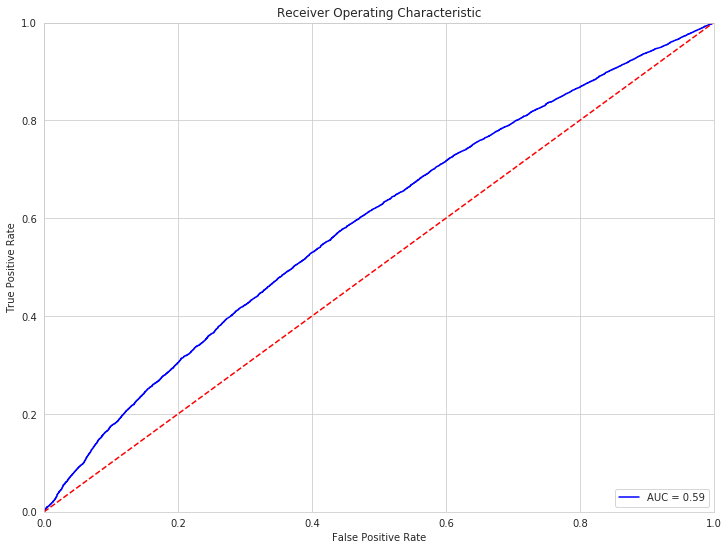

In [0]:
#plot roc-auc curve
plot_roc_auc(text_classification_test_reduced.published, pred_rnn_oversample_glove_ratio2_class.prob_pred)

In [0]:
#print resulats for both models
print("F1 BOW Oversampled Glove:", f1_bow_oversample_glove_ratio2)
print("F1 RNN Oversampled Glove:", f1_rnn_oversample_glove_ratio2)

print("AUC BOW Oversampled Glove:", auc_bow_oversample_glove_ratio2)
print("AUC RNN Oversampled Glove:", auc_rnn_oversample_glove_ratio2)

print("ACC BOW Oversampled Glove:", acc_bow_oversample_glove_ratio2)
print("ACC RNN Oversampled Glove:", acc_rnn_oversample_glove_ratio2)

F1 BOW Oversampled Glove: 0.8995035827399539
F1 RNN Oversampled Glove: 0.9174405929801612
AUC BOW Oversampled Glove: 0.6278661794222751
AUC RNN Oversampled Glove: 0.5883041914740764
ACC BOW Oversampled Glove: 0.82104
ACC RNN Oversampled Glove: 0.84852


#### Comparing Results of different Ratios of published and not published comments

In [0]:
#prepare dataframe for visualization
data = {'Model':['BOW', 'BOW', 'BOW', 'BOW', 'RNN', 'RNN', 'RNN', 'RNN', 'BOW', 'BOW', 'BOW', 'BOW', 'RNN', 'RNN', 'RNN', 'RNN', 'BOW', 'BOW', 'BOW', 'BOW', 'RNN', 'RNN', 'RNN', 'RNN'],
        'Metric':['F1', 'F1', 'F1', 'F1', 'F1', 'F1', 'F1', 'F1', 'AUC', 'AUC', 'AUC', 'AUC', 'AUC', 'AUC', 'AUC', 'AUC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC'],
        'Setting':['Imbalanced', 'Oversample GloVe', 'Oversample GloVe Ratio 1', 'Oversample GloVe Ratio 2', 'Imbalanced', 'Oversample GloVe', 'Oversample GloVe Ratio 1', 'Oversample GloVe Ratio 2', 'Imbalanced', 'Oversample GloVe', 'Oversample GloVe Ratio 1', 'Oversample GloVe Ratio 2', 'Imbalanced', 'Oversample GloVe', 'Oversample GloVe Ratio 1', 'Oversample GloVe Ratio 2', 'Imbalanced', 'Oversample GloVe', 'Oversample GloVe Ratio 1', 'Oversample GloVe Ratio 2', 'Imbalanced', 'Oversample GloVe', 'Oversample GloVe Ratio 1', 'Oversample GloVe Ratio 2'],
        'Ratio':['Imbalanced', '50:50', 'Ratio 1', 'Ratio 2', 'Imbalanced', '50:50', 'Ratio 1', 'Ratio 2', 'Imbalanced', '50:50', 'Ratio 1', 'Ratio 2', 'Imbalanced', '50:50', 'Ratio 1', 'Ratio 2', 'Imbalanced', '50:50', 'Ratio 1', 'Ratio 2', 'Imbalanced', '50:50', 'Ratio 1', 'Ratio 2'],
        'Value':[f1_bow_imbalanced, f1_bow_oversample_glove, f1_bow_oversample_glove_ratio1, f1_bow_oversample_glove_ratio2, 
                 f1_rnn_imbalanced, f1_rnn_oversample_glove, f1_rnn_oversample_glove_ratio1, f1_rnn_oversample_glove_ratio2,
                 auc_bow_imbalanced, auc_bow_oversample_glove, auc_bow_oversample_glove_ratio1, auc_bow_oversample_glove_ratio2, 
                 auc_rnn_imbalanced, auc_rnn_oversample_glove, auc_rnn_oversample_glove_ratio1, auc_rnn_oversample_glove_ratio2,
                 acc_bow_imbalanced, acc_bow_oversample_glove, acc_bow_oversample_glove_ratio1, acc_bow_oversample_glove_ratio2, 
                 acc_rnn_imbalanced, acc_rnn_oversample_glove, acc_rnn_oversample_glove_ratio1, acc_rnn_oversample_glove_ratio2]}

results_ratio_df = pd.DataFrame(data)

results_ratio_df.head()

,Model,Metric,Setting,Ratio,Value
0,BOW,F1,Imbalanced,Imbalanced,0.922541
1,BOW,F1,Oversample GloVe,50:50,0.817953
2,BOW,F1,Oversample GloVe Ratio 1,Ratio 1,0.873023
3,BOW,F1,Oversample GloVe Ratio 2,Ratio 2,0.899504
4,RNN,F1,Imbalanced,Imbalanced,0.931204


##### Visualize Results of different Ratios

In [0]:
#setting ffigure size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

<Figure size 720x360 with 0 Axes>

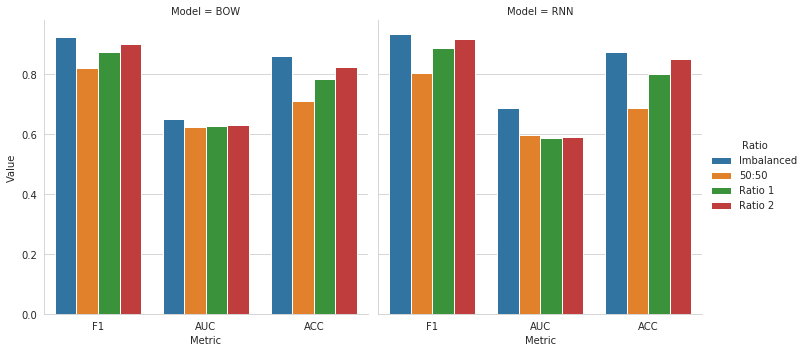

In [0]:
#plot results
plt.figure(figsize=(10,5))

chart = sns.catplot(x="Metric", y="Value", hue="Ratio", col="Model", data=results_ratio_df, kind="bar", ci=None)